<a href="https://colab.research.google.com/github/Giuseppe86-lab/Filtro_Anti-Hater_per_Social_Network/blob/main/Progetto_Toxic_Comments_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

# 0 Utilitis

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
pip install iterative-stratification

In [ ]:
pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install nltk

In [ ]:
pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 126.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1 Setup e Librerie

In [ ]:
# Librerie per manipolazione dati
import pandas as pd
import numpy as np
from collections import Counter

#Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing e valutazione
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import resample
from skmultilearn.model_selection import iterative_train_test_split


#Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 2 Caricamento del Dataset

In [ ]:
#BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
#df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")
df = pd.read_csv('Filter_Toxic_Comments_dataset.csv')
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In questo dataset abbiamo 159571 commenti, per quanto riguarda le features:

1. **comment_text**: dove troviamo il testo del commeto.
2. le sei possibili etichette del commento negativo: **toxc**, **several_toxic**, **obcene**, **threat**, **insult**, **identity_hate**.
3. **sum_injurious**: variabile di servizione che conta quante etichette sono state assegnato al singolo commento.

Controlliamo che non ci siano commenti duplicati:

In [ ]:
duplicati = df.duplicated().sum()
print(f'Numero di righe duplicate (tutte le colonne identiche): {duplicati}')

duplicati_testo = df.duplicated(subset=['comment_text']).sum()
print(f'Numero di commenti duplicati: {duplicati_testo}')

Numero di righe duplicate (tutte le colonne identiche): 0
Numero di commenti duplicati: 0


#3 Analisi Esplorativa dei Dati (EDA)

In questa fase investigheremo:
- Come è distribuita ogni categoria di tossicità?
- Quanti commenti hanno più di un'etichetta?
- Quanti non ne hanno nessuna?


 Distribuzione delle etichette:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


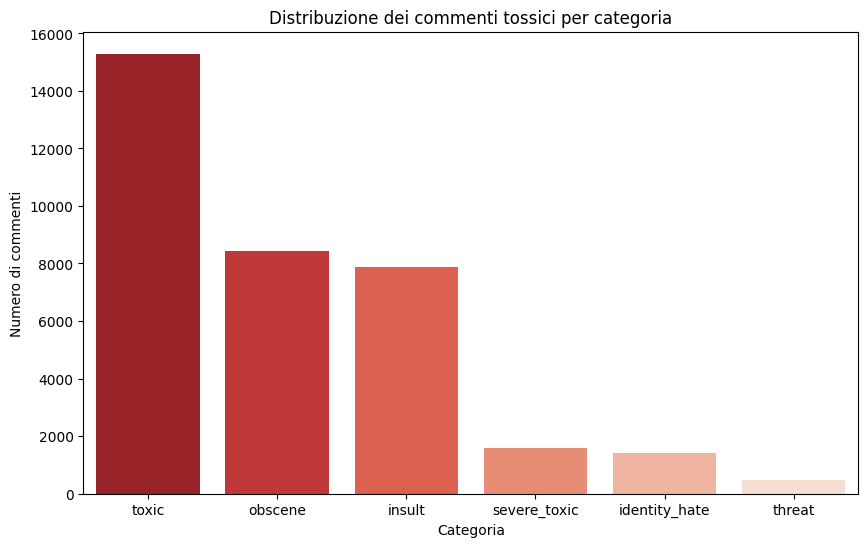

In [ ]:
#Etichette target
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Somma delle etichette per categoria
label_counts = df[labels].sum().sort_values(ascending=False)
print('\n Distribuzione delle etichette:')
print(label_counts)

#Grafico distribuzione delle etichette
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Reds_r')
plt.title('Distribuzione dei commenti tossici per categoria')
plt.ylabel('Numero di commenti')
plt.xlabel('Categoria')
plt.show()

In [ ]:
# Calcolo e stampa della distribuzione del numero di etichette per commento
counts = df['sum_injurious'].value_counts().sort_index()
percents = df['sum_injurious'].value_counts(normalize=True).sort_index() * 100

print('\nDistribuzione del numero di etichette per commento:')
print('Numero etichette | Conteggio | Percentuale')
for i in counts.index:
    print(f'       {i}        |   {counts[i]:6}  |   {percents[i]:6.2f}%')



Distribuzione del numero di etichette per commento:
Numero etichette | Conteggio | Percentuale
       0        |   143346  |    89.83%
       1        |     6360  |     3.99%
       2        |     3480  |     2.18%
       3        |     4209  |     2.64%
       4        |     1760  |     1.10%
       5        |      385  |     0.24%
       6        |       31  |     0.02%


Vediamo che circa il 90% dei commenti non è tossico, questo dato insieme al fatto che alcune categorie di tossicità siano sotto rappresentate dovrà essere gestito in fase di preprocessing dei dati.

Come ultima parte della fase Esplorativa dei Dati, studiamo le 'correlazioni' tra le diverse etichette.

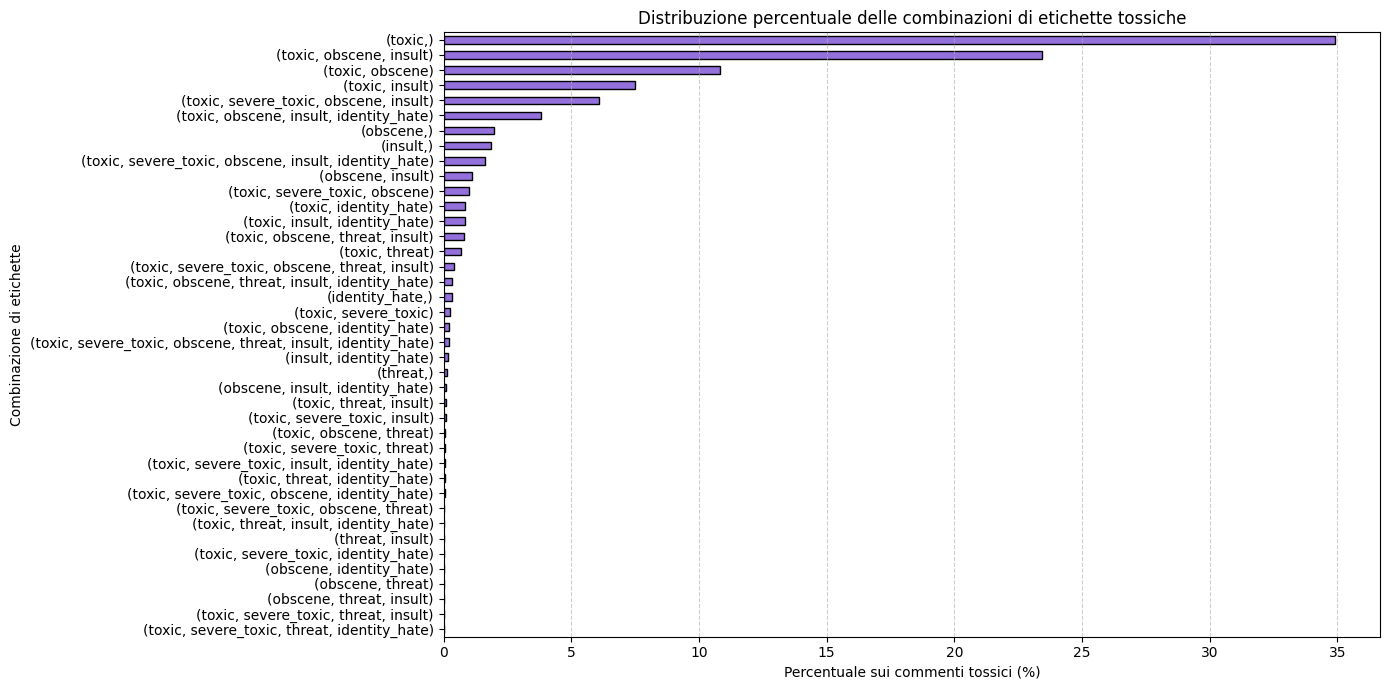

In [ ]:
df_labeled = df[df['sum_injurious']>0].copy()

#Colonna con tuple delle etichette attive
df_labeled['label_combo'] = df_labeled[labels].apply(
    lambda row: tuple(label for label, val in row.items() if val==1),
    axis=1)

#Conteggio delle combinazioni
combo_counts = df_labeled['label_combo'].value_counts()
combo_percents = (combo_counts /len(df_labeled))*100
combo_percents = combo_percents.sort_values()

plt.figure(figsize=(14,7))
combo_percents.plot(kind='barh',color='mediumpurple',edgecolor='black')
plt.title('Distribuzione percentuale delle combinazioni di etichette tossiche')
plt.ylabel('Combinazione di etichette')
plt.xlabel('Percentuale sui commenti tossici (%)')
plt.grid(axis='x', linestyle='--', alpha = 0.6)
plt.tight_layout()
plt.show()

Possiamo osservare che delle 40 combinazioni individuate quelle che mostrano una presenza maggiore del 5% sono:
- (toxic, severe_toxic, obscene, insult)
- (toxic, insult)
- (toxic, obscene)
- (toxic, obscene, insult)
- (toxic)
Queste 5 da solo esauriscono circa l'80% dei commenti tossici.

Costruiamo altre due rappresentazioni:
- Un istogramma a barre normalizzate: per mostrare come ogni etichetta si suddivide in combinazioni con le altre
- Una heatmap tra coppie di etichette.

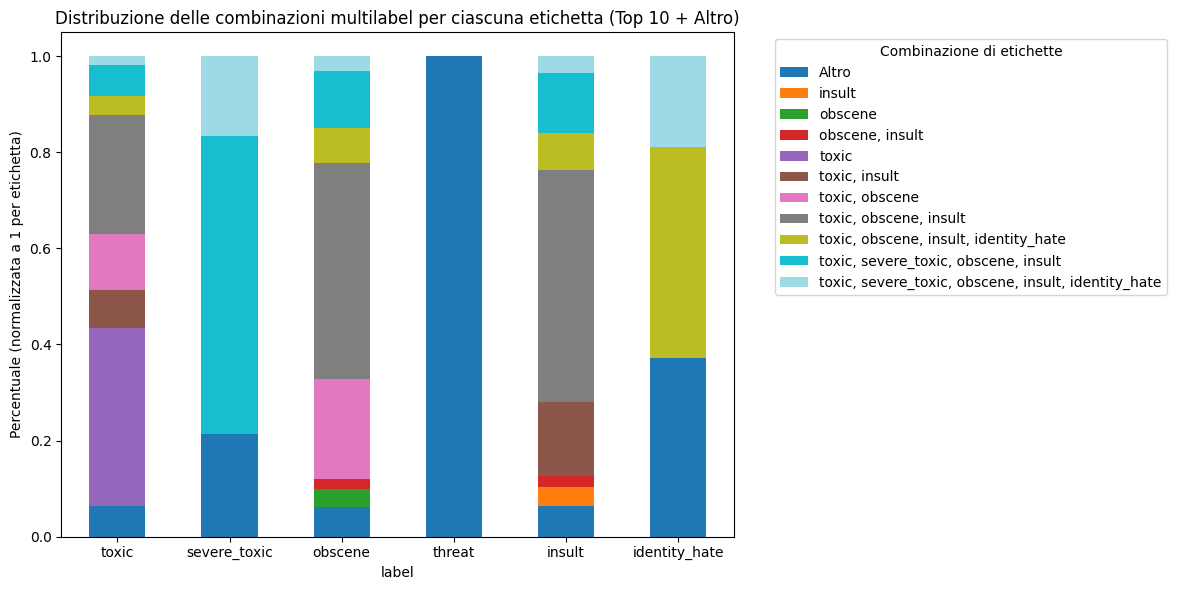

In [ ]:
# Per ogni etichetta, contiamo le combo in cui compare
data = []

#Calcolo delle combinazioni
all_combos = df_labeled['label_combo']
combo_counts = Counter(all_combos)
top_10_combos = set([combo for combo, _ in combo_counts.most_common(10)])

for label in labels:
  subset = df_labeled[df_labeled[label]==1]
  combos = subset['label_combo']
  counter = Counter(['Altro' if combo not in top_10_combos else combo for combo in combos])
  total = sum(counter.values())

  for combo, count in counter.items():
    combo_str = ', '.join(combo) if combo != 'Altro' else 'Altro'
    data.append({
        'label': label,
        'combo': combo_str,
        'percent': count/total #normalizzato a 1 per ogni label
    })

combo_dist_df = pd.DataFrame(data)
pivot_df = combo_dist_df.pivot(index='label', columns='combo', values='percent').fillna(0)
pivot_df=pivot_df.loc[labels]

pivot_df.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title('Distribuzione delle combinazioni multilabel per ciascuna etichetta (Top 10 + Altro)')
plt.ylabel('Percentuale (normalizzata a 1 per etichetta)')
plt.xticks(rotation = 0)
plt.legend(title='Combinazione di etichette', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Da questo istogramma notiamo come per oltre il 70% dei casi **toxic** compaia associato con altre etichette, questa tendenza con una percentuale di circa il 90% è presenta anche in **insult**.
Già da questa analisi possiamo ipotizzare che dovremmo prestare particolare attenzione a **threat** perché non solo è poco rappresentata ma anche combinata con altre label è coinvolta solo in combinazioni rare, tant'è che la sua colonna mostra solo **altro**, cioè combinazioni che non sono nelle prime 10 più frequenti.

Mostriamo una heatmap delle co-occorrenze in cui le percentuali sono calcolate solo sui commenti dove l'etichetta di riferimento compare insieme ad almeno un'altra etichetta (escludendo i casi singoli).

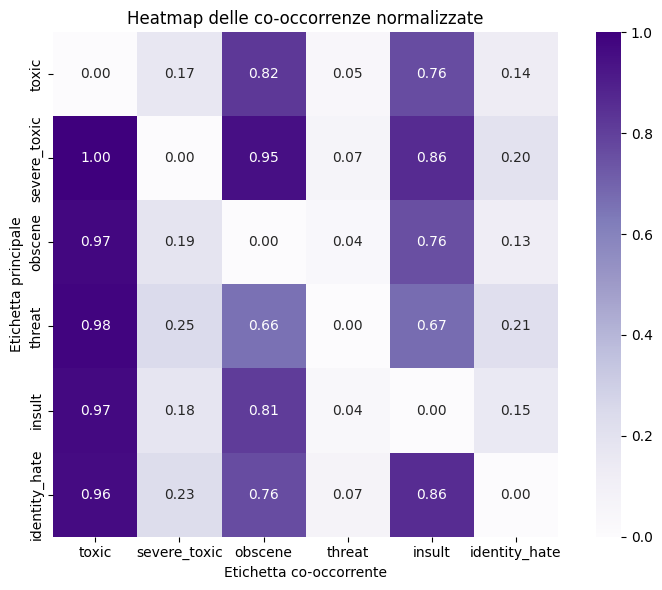

In [ ]:
co_occurence_matrix = pd.DataFrame(0.0, index = labels, columns=labels)

#Calcolo delle co-occorrenze normalizzate

for label1 in labels:
  filtered = df[(df[label1]==1)&(df['sum_injurious']>1)]
  total = len(filtered)

  for label2 in labels:
    if label1 == label2:
      co_occurence_matrix.loc[label1, label2] = 0.0
    else:
      if total > 0:
        percent = (filtered[label2]==1).sum()/total
        co_occurence_matrix.loc[label1, label2] = percent


plt.figure(figsize=(8,6))
sns.heatmap(co_occurence_matrix, annot = True, cmap='Purples', fmt='.2f', square=True)
plt.title('Heatmap delle co-occorrenze normalizzate')
plt.xlabel('Etichetta co-occorrente')
plt.ylabel('Etichetta principale')
plt.tight_layout()
plt.show()

Per leggere questa heatmap dobbiamo considerare che la normalizzazione è fatta per righe, dovei si considerano solo i commenti in cui l'etichetta principale appare associata ad altre etichette, per questo non è simmetrica. Possiamo notare alcune cose interessanti:
- **toxic**: nell'80% dei casi compare con **obscene** e **insult**;
- **severe_toxic**: compare sempre con **toxic** e spessissimo con **obscene** e **insult**;
- **obscene**: 97% con **toxic** e 76% con **insult**;
- **threat**: 98% con **toxic** e circa 70% con **obscene** e **insult**;
- **insult**: 97% con **toxic** e 80% con **obscene**;
- **identity_hate**: 96% con **toxic* e circa l'80% con **obscen** e **insult**.

Si nota quindi come tutte le etichette quando non sono uniche si associano con una percentuale oltre il 95% con **toxic**, anche **obscene** e **insult** presentano percentuali molto alte di accoppiamenti multilabel.

Facciamo adesso un'analisi esplorativa della lunghezza dei singoli commenti:

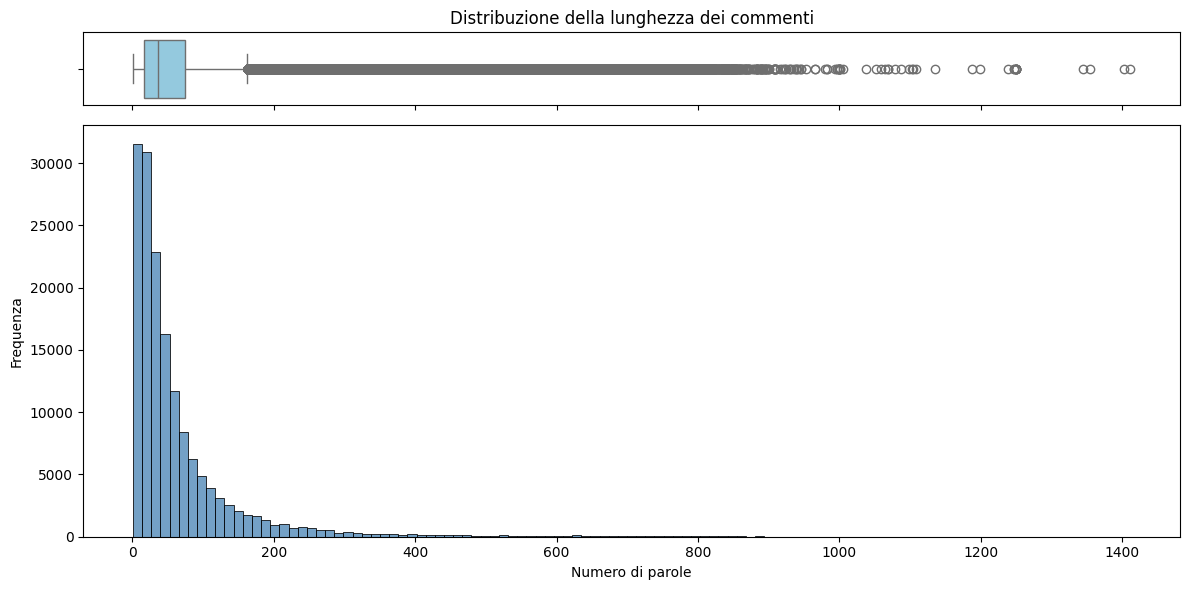

In [ ]:
#Aggiungo una colonna con la lunghezza di ciascun commento
df['comment_length'] = df['comment_text'].str.split().apply(len)

#Istogramma e boxplor della lughezza dei commenti
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize = (12, 6), sharex = True,
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

sns.boxplot(x=df['comment_length'], ax = ax_box, color = 'skyblue')
ax_box.set(xlabel='')
ax_box.set_title('Distribuzione della lunghezza dei commenti')

sns.histplot(df['comment_length'], bins='rice', ax = ax_hist, color = 'steelblue')
ax_hist.set_xlabel('Numero di parole')
ax_hist.set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

Vediamo che la maggior parte dei commenti hanno una lunghezza minore di 300 parole ma entrambi i grafici presentano degli outlier con commenti anche con 1400 parole, vediamo se queste distribuzioni sono sensibili alle etichette.

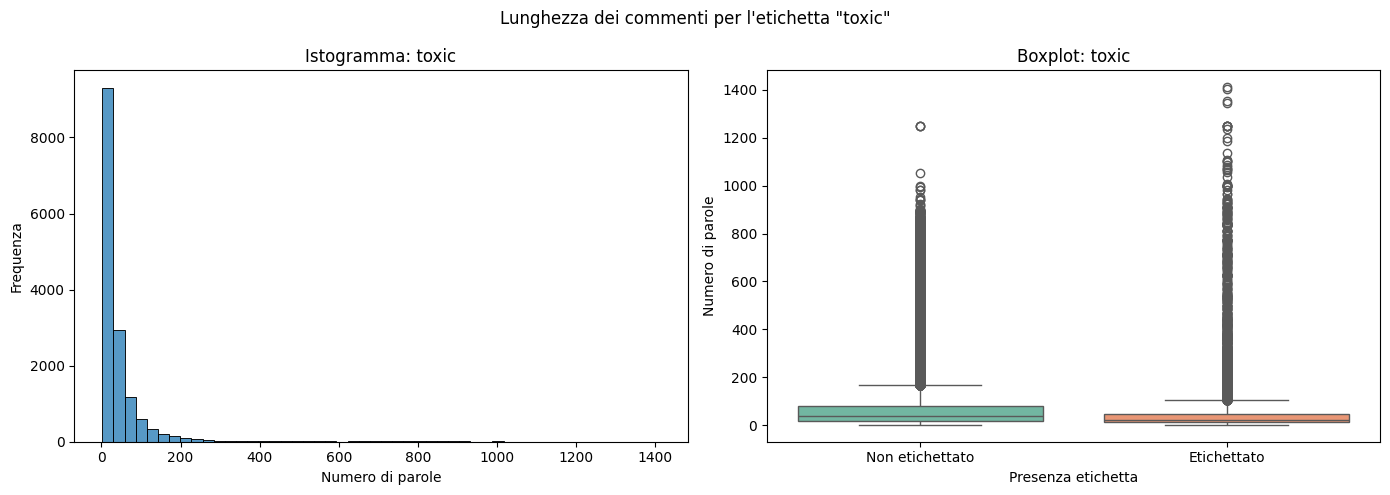

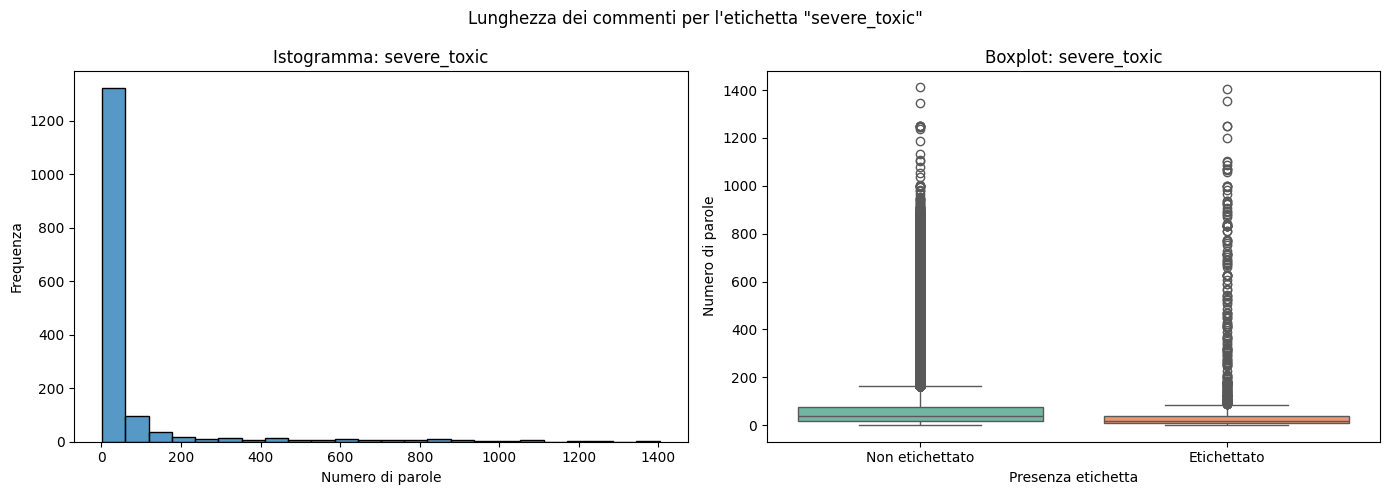

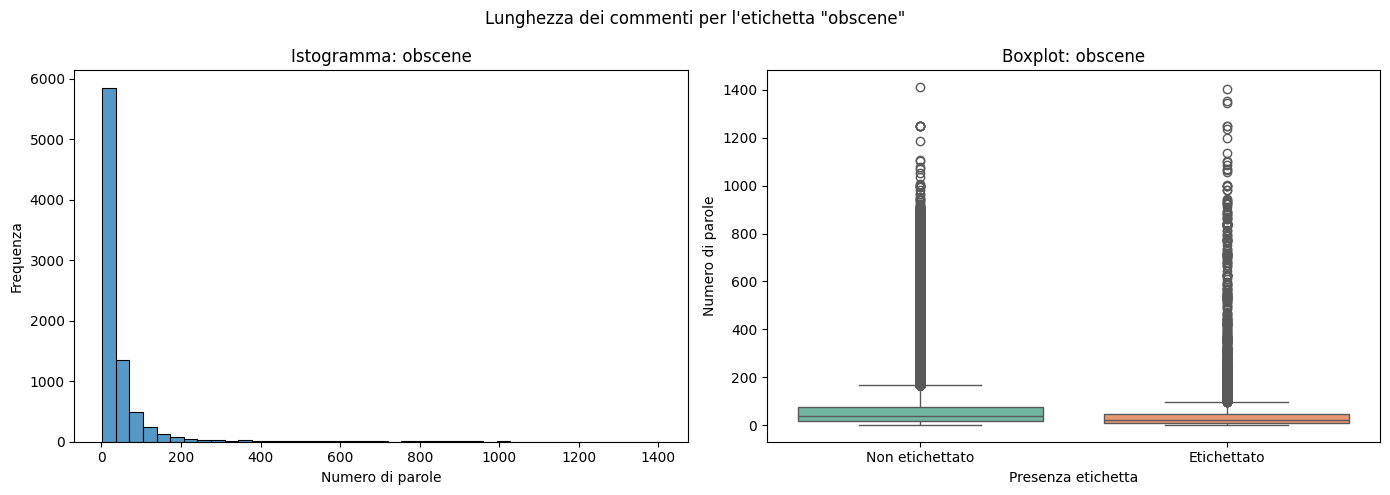

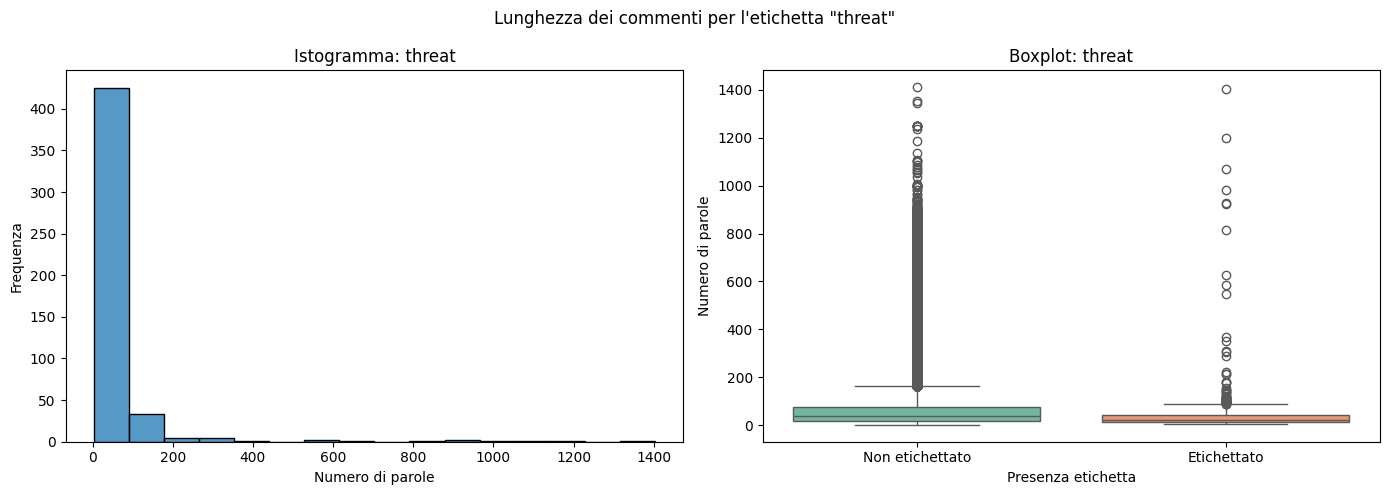

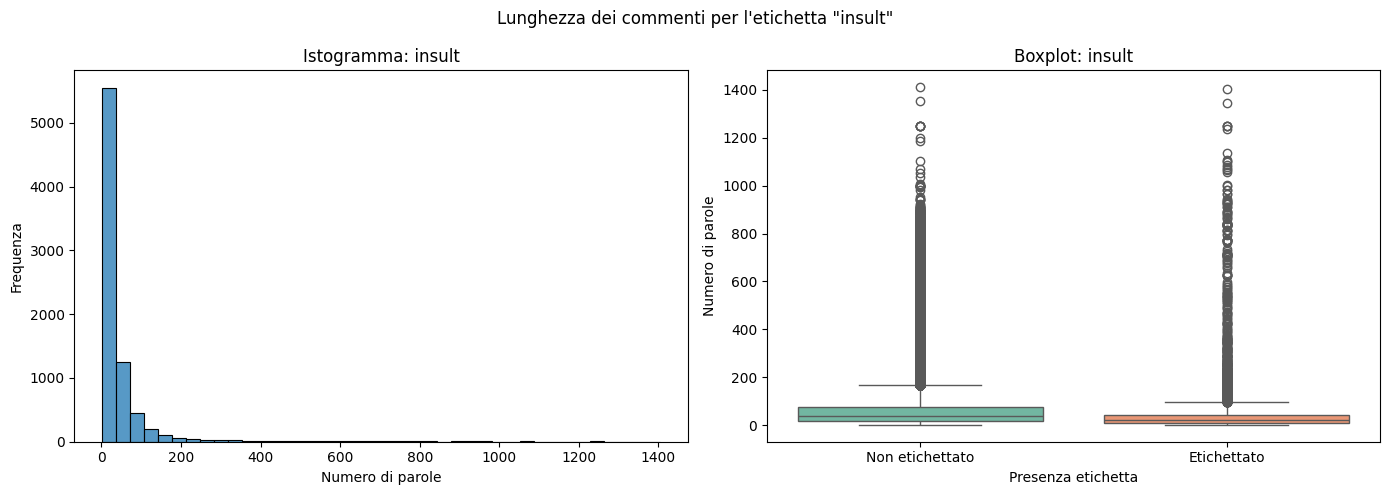

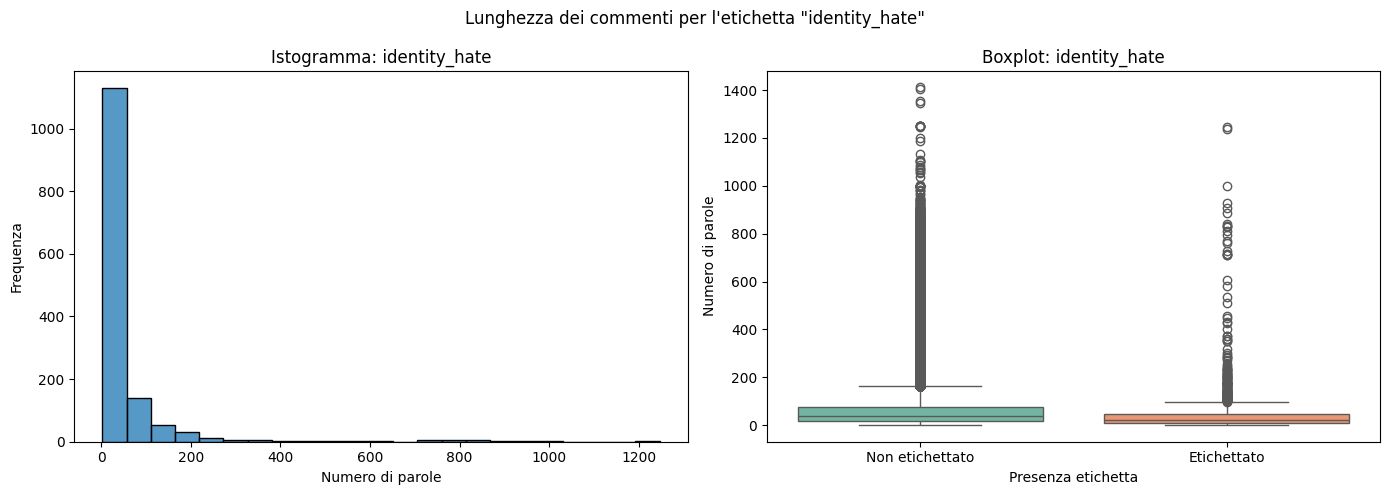

In [ ]:
for label in labels:
  fig, axes = plt.subplots(1,2, figsize = (14, 5))
  fig.suptitle(f'Lunghezza dei commenti per l\'etichetta "{label}"')

  sns.histplot(data = df[df[label]==1], x = 'comment_length', bins='rice', ax=axes[0], palette='Set2')
  axes[0].set_title(f'Istogramma: {label}')
  axes[0].set_xlabel('Numero di parole')
  axes[0].set_ylabel('Frequenza')

  sns.boxplot(data = df, x = label, y = 'comment_length', ax = axes[1], palette='Set2')
  axes[1].set_title(f'Boxplot: {label}')
  axes[1].set_xticklabels(['Non etichettato', 'Etichettato'])
  axes[1].set_xlabel('Presenza etichetta')
  axes[1].set_ylabel('Numero di parole')

  plt.tight_layout()
  plt.show()

Vediamo che dal punto di vista delle distribuzioni sono tutte molto simili con una forte assimetria a destra, questo vuol dire che come maxlen converra usare degli accorgimenti per evitare di usare un pad eccessivo, proveremo a fissare la maxlen al 95 percentile.

#4 Pulizia del testo, tokenizzazione, splitting
Prepariamo il testo per poter essere usato come input per il nostro modello di deep learning, per adesso non facciamo il bilanciamento del dataset per poter avere una baseline per giudicare i nostri modelli.

Definiamo due funzioni:
- clean_text: elimina indirizzi mail, URL, riduce le lettere ripeture, rimuove la punteggiatura, lemmizza le parole, rimuove le stopwords, elimina numeri, caratteri non alfabetici e spazi multipli.
- prepare_sequences: trasforma il testo in sequenze ed esegue il padding.

Come maxlen abbiamo scelto il 95° percentile della lunghezza dei nostri commenti dopo la pulizia.

Dopo procederemo con la suddivisione del dataset in train, test e validation


In [ ]:
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def clean_text(text):
  text = text.lower()
  # Rimuovi URL ed email
  text = re.sub(r"http\S+|www\S+|https\S+", '', text)
  text = re.sub(r"\S+@\S+", '', text)

  # Riduci lettere ripetute (es. noooo -> no)
  text = re.sub(r'(.)\1{2,}', r'\1', text)
  for c in punctuation:
    text = text.replace(c, ' ') #rimuovere punteggiatura

  document = nlp(text)
  text = ' '.join(token.lemma_ for token in document)
  text = ' '.join(word for word in text.split() if word not in english_stopwords) #rimuovere stopwords
  text = re.sub(r'\d+', '', text) #rimuovere numeri
  text = re.sub(" +", " ", text)
  text = re.sub(r"[^a-z\s]", "", text) #rimuovere caratteri non alfabetici

  return text

NameError: name 'nltk' is not defined

In [ ]:
def prepare_sequences(tokenizer, texts, maxlen):
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences, maxlen = maxlen, padding = 'post', truncating = 'post')
  return padded

In [ ]:
#Applichiamo la pulizia al testo
df['clean_text'] = df['comment_text'].apply(clean_text)

In [ ]:
X = df['clean_text'].values
y = df[labels].values

In [ ]:
#Splitting in Train, Validatio e Test
RANDOM_SEED = 42
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state = RANDOM_SEED)
for train_idx, temp_idx in msss.split(X, y):
  X_train, X_temp = X[train_idx], X[temp_idx]
  y_train, y_temp = y[train_idx], y[temp_idx]

msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=RANDOM_SEED)
for val_idx, test_idx in msss_val_test.split(X_temp, y_temp):
  X_val, X_test = X_temp[val_idx], X_temp[test_idx]
  y_val, y_test = y_temp[val_idx], y_temp[test_idx]

In [ ]:
#Calcolo di MAX_LEN solo sul training set
max_len_train = int(np.percentile([len(x.split()) for x in X_train], 95))
print(f'Max Len (95° percentile): {max_len_train}')

Max Len (95° percentile): 115


In [ ]:
VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

#Applichiamo la tokenizzazione a tutti i set e costruiamo le sequenze
X_train_seq = prepare_sequences(tokenizer, X_train, max_len_train)
X_val_seq = prepare_sequences(tokenizer, X_val, max_len_train)
X_test_seq = prepare_sequences(tokenizer, X_test, max_len_train)

print("Shape train: ", X_train_seq.shape)
print("Shape val: ", X_val_seq.shape)
print("Shape test: ", X_test_seq.shape)

Shape train:  (111699, 115)
Shape val:  (31914, 115)
Shape test:  (15958, 115)


# 5.1.A Costruzione e addestramento modello LSTM - Senza Bilanciamento

In [ ]:
def build_lstm_model(vocab_size, embedding_dim, lstm_units, input_length, output_dim):
  model = Sequential([
      Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = input_length),
      LSTM(lstm_units, return_sequences = False),
      Dropout(0.5),
      Dense(64, activation = 'relu'),
      Dropout(0.5),
      Dense(output_dim, activation = 'sigmoid')
  ])

  model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['binary_accuracy']
  )

  model.build(input_shape = (None, input_length))
  print(model.summary())

  return model

In [ ]:
def plot_training_history(history):
  fig, axes = plt.subplots(1, 2, figsize=(12,4))

  #Loss
  axes[0].plot(history.history['loss'], label='Train Loss')
  axes[0].plot(history.history['val_loss'], label='Validation Loss')
  axes[0].set_title('Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Binary Crossentropy')
  axes[0].legend()

  #Accuracy
  axes[1].plot(history.history['binary_accuracy'], label='Train Accuracy')
  axes[1].plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
  axes[1].set_title('Binary Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Binary Accuracy')
  axes[1].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
#Parametri
embedding_dim = 128
lstm_units = 64

model = build_lstm_model(
    vocab_size = VOCAB_SIZE,
    embedding_dim = embedding_dim,
    lstm_units = lstm_units,
    input_length = max_len_train,
    output_dim = len(labels)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 115, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,613,958 (9.97 MB)

 Trainable params: 2,613,958 (9.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#Addestramento
history = model.fit(
    X_train_seq, y_train,
    validation_data = (X_test_seq, y_test),
    epochs = 5,
    batch_size = 32,
    verbose=1
)

Epoch 1/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - binary_accuracy: 0.9575 - loss: 0.1694 - val_binary_accuracy: 0.9635 - val_loss: 0.1403
Epoch 2/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - binary_accuracy: 0.9646 - loss: 0.1367 - val_binary_accuracy: 0.9791 - val_loss: 0.0607
Epoch 3/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - binary_accuracy: 0.9791 - loss: 0.0600 - val_binary_accuracy: 0.9825 - val_loss: 0.0516
Epoch 4/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - binary_accuracy: 0.9820 - loss: 0.0482 - val_binary_accuracy: 0.9827 - val_loss: 0.0492
Epoch 5/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - binary_accuracy: 0.9838 - loss: 0.0422 - val_binary_accuracy: 0.9826 - val_loss: 0.0515


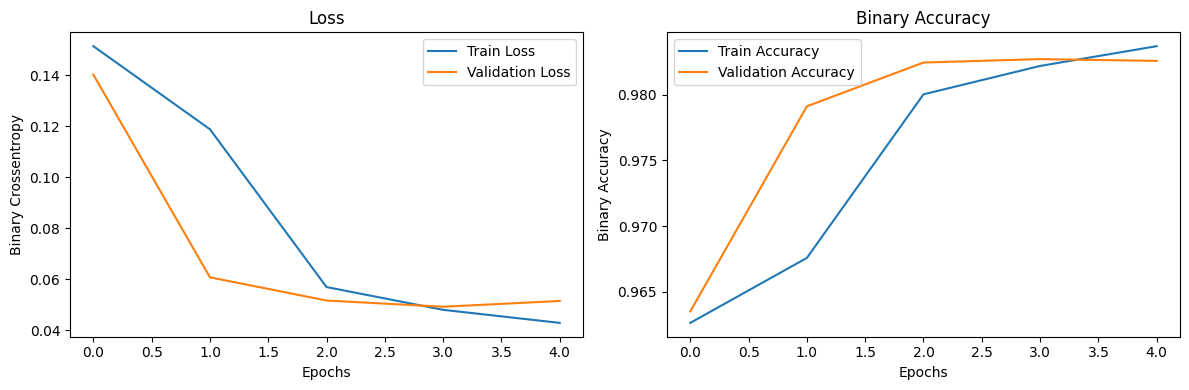

In [ ]:
plot_training_history(history)

#5.1.B Analisi Modello1 e definizione funzioni per valutazione

In [ ]:
def find_best_threshold(y_true, y_pred_prob, thresholds = np.arange(0.1, 0.9, 0.05)):
  """
  Trova la soglia ottimale che massimizza il F1-score micro.


  Args:
    y_true (ndarray): array binario con le etichette vere
    y_pred_prob (ndarray): array con le probabilità predette dal modello
    thresholds (iterable): intervallo di soglie da testare

  Returns:
    best_threshold (float): soglia ottimale per massimizzare il F1-score micro
    best_score (float): valore del F1 micro della soglia ottimale
  """
  best_score = -1
  best_threshold = 0.5

  for thesh in thresholds:
    y_pred = (y_pred_prob >= thesh).astype(int)
    score = f1_score(y_true, y_pred, average='micro')

    if score > best_score:
      best_score = score
      best_threshold = thesh

  print(f"Soglia ottimale trovata: {best_threshold:.2f} (F1 micro = {best_score:.4f})")
  return best_threshold, best_score

In [ ]:
def analyze_multilabel_performance(y_true, y_pred_prob, labels, threshold=0.5):
  #Binarizzazione delle predizioni
  y_pred = (y_pred_prob >= threshold).astype(int)

  #Report per classe
  report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
  report_df = pd.DataFrame(report).T.iloc[:-3]

  #Heatmap delle metriche per etichette
  plt.figure(figsize=(8,4))
  sns.heatmap(report_df[['precision','recall','f1-score']], annot=True, cmap='Blues', fmt = '.2f')
  plt.title("Precisione, Recall, F1-score per etichetta")
  plt.show()

  #Confusion matrix per etichetta
  fig, axes = plt.subplots(2, 3, figsize=(15, 8))
  axes = axes.flatten()
  for i, label in enumerate(labels):
    cm = pd.crosstab(y_true[:, i], y_pred[:, i], rownames=['True'], colnames=['Pred'], normalize='index')
    sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {label}')

  plt.tight_layout()
  plt.show()

  #Metriche globali
  print("Valutazione globale:")
  print(f'Subset accuracy: {accuracy_score(y_true, y_pred):.4f}')
  print(f'F1 micro: {f1_score(y_true, y_pred, average="micro"):.4f}')
  print(f'F1 macro: {f1_score(y_true, y_pred, average="macro"):.4f}')
  print(f'Precision micro: {precision_score(y_true, y_pred, average="micro"):.4f}')
  print(f'Precision macro: {precision_score(y_true, y_pred, average="macro"):.4f}')
  print(f'Recall micro: {recall_score(y_true, y_pred, average="micro"):.4f}')
  print(f'Recall macro: {recall_score(y_true, y_pred, average="macro"):.4f}')

  return report_df

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Soglia ottimale trovata: 0.35 (F1 micro = 0.7989)


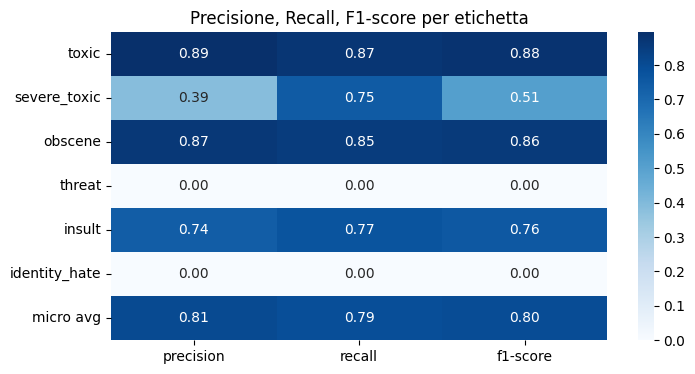

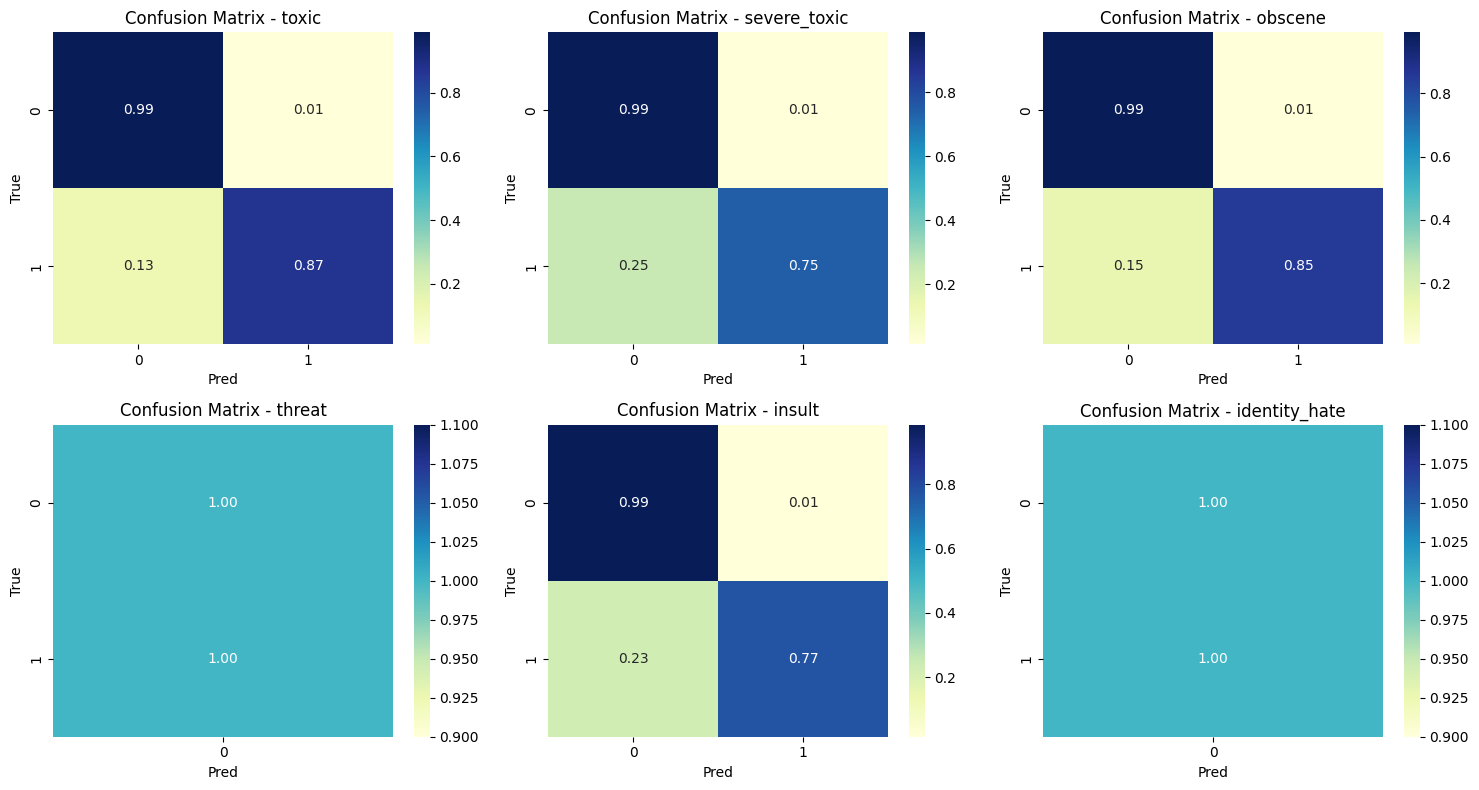

Valutazione globale:
Subset accuracy: 0.9326
F1 micro: 0.7989
F1 macro: 0.5012
Precision micro: 0.8057
Precision macro: 0.4813
Recall micro: 0.7922
Recall macro: 0.5401


,precision,recall,f1-score,support
toxic,0.894943,0.872875,0.883772,10706.0
severe_toxic,0.387879,0.745520,0.510273,1116.0
obscene,0.865051,0.850862,0.857898,5914.0
threat,0.000000,0.000000,0.000000,335.0
insult,0.739652,0.771309,0.755149,5514.0
identity_hate,0.000000,0.000000,0.000000,983.0
micro avg,0.805746,0.792169,0.798900,24568.0


In [ ]:
y_train_pred_prob = model.predict(X_train_seq)
best_thres, best_score = find_best_threshold(y_train, y_train_pred_prob)
analyze_multilabel_performance(y_train, y_train_pred_prob, labels, best_thres)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


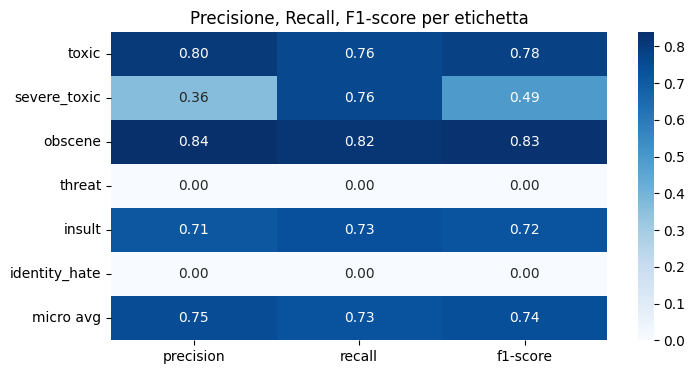

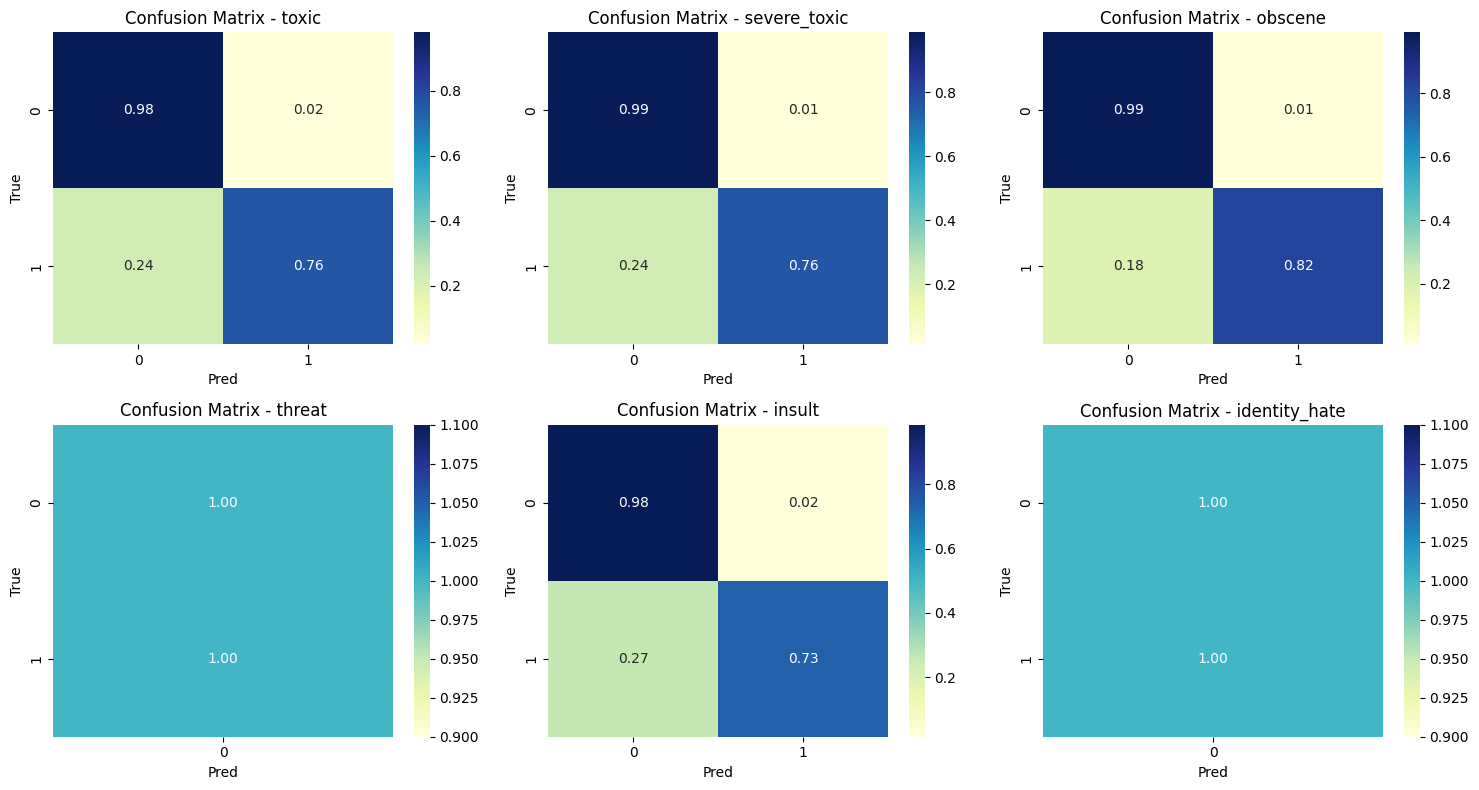

Valutazione globale:
Subset accuracy: 0.9139
F1 micro: 0.7369
F1 macro: 0.4706
Precision micro: 0.7466
Precision macro: 0.4528
Recall micro: 0.7274
Recall macro: 0.5123


,precision,recall,f1-score,support
toxic,0.802205,0.761282,0.781208,1529.0
severe_toxic,0.363095,0.762500,0.491935,160.0
obscene,0.838200,0.815385,0.826635,845.0
threat,0.000000,0.000000,0.000000,48.0
insult,0.713054,0.734772,0.723750,788.0
identity_hate,0.000000,0.000000,0.000000,141.0
micro avg,0.746565,0.727428,0.736872,3511.0


In [ ]:
y_test_pred_prob = model.predict(X_test_seq)
analyze_multilabel_performance(y_test, y_test_pred_prob, labels, best_thres)

Possiamo osservare come le statistiche siano molto simili tra il train e il test set segno che il modello non soffre di overfitting.

Il problema principale è che il modello funziona bene per le classi più frequenti (**toxic, obscene, insult**), ma fallisce completamente sulle classi con meno dati.

Questo rende necessario procedere con una strategia di bilanciamento.

# 5.2.A Costruzione e addestramento modello LSTM - Con Bilanciamento

In [ ]:
def multilabel_oversample(X_texts, y_labels, strategy='mean'):
  X_texts = pd.Series(X_texts)
  X_df = pd.DataFrame({'comment_text': X_texts})
  y_df = pd.DataFrame(y_labels)

  label_counts = y_df.sum(axis=0)

  if strategy == 'mean':
    target_count = int(np.round(label_counts.mean()))
  else:
    raise ValueError("Invalid strategy. Choose 'mean'.")

  print(f"Distribuzione originale delle etichette:\n{label_counts}\nPercentuale rispetto alla classe più frequente:\n{round(label_counts/label_counts[0]*100,0)}")
  print(f"\nNumero di esempi minimo desiderato per ogni classe: {target_count}")

  X_bal = []
  y_bal = []

  for label in y_df.columns:
    pos_indices = y_df[y_df[label]==1].index
    n_pos = len(pos_indices)

    if n_pos < target_count:
      diff = target_count - n_pos
      sampled_indices = resample(pos_indices, replace=True, n_samples=diff, random_state=RANDOM_SEED)
      X_bal.append(X_df.loc[sampled_indices, 'comment_text'])
      y_bal.append(y_df.loc[sampled_indices])

  #Concateniamo tutti gli esempi aggiuntivi al training set originale
  X_aug = pd.concat([X_df]+X_bal, ignore_index = True)
  y_aug = pd.concat([y_df]+y_bal, ignore_index = True)

  label_counts = y_aug.sum(axis=0)
  print(f"\nDistribuzione originale delle etichette:\n{label_counts}\nPercentuale rispetto alla classe più presente:\n{round(label_counts/label_counts[0]*100,0)}")

  return X_aug.values, y_aug.values


In [ ]:
X_train_bal, y_train_bal = multilabel_oversample(X_train, y_train)

Distribuzione originale delle etichette:
0    10706
1     1116
2     5914
3      335
4     5514
5      983
dtype: int64
Percentuale rispetto alla classe più frequente:
0    100.0
1     10.0
2     55.0
3      3.0
4     52.0
5      9.0
dtype: float64

Numero di esempi minimo desiderato per ogni classe: 4095

Distribuzione originale delle etichette:
0    20118
1     5723
2    13332
3     4522
4    13019
5     5429
dtype: int64
Percentuale rispetto alla classe più presente:
0    100.0
1     28.0
2     66.0
3     22.0
4     65.0
5     27.0
dtype: float64


È normale che anche le classi più frequenti abbiano subito un oversampling in quanto i commenti sono multietichetta.

Possiamo però notare come le etichette meno rappresentate, che prima comparivano con una percentuale rispetto alla più frequente del 10, 9 e 3%, adesso compaiano rispettivamente con il 28, 27 e 22%. Questo aumento è sicuramente significato, vedremo se aiuterà il modello ad individuare anche queste classi.

Come primo step addestriamo un modello con le stesse caratteristiche di quelle al punto 5.1 ma usando come X_train e y_train i nuovi set bilanciati.

In [ ]:
X_train_bal_seq = prepare_sequences(tokenizer, [str(text) for text in X_train_bal], max_len_train)

In [ ]:
#Parametri
embedding_dim = 128
lstm_units = 64

model_bal = build_lstm_model(
    vocab_size = VOCAB_SIZE,
    embedding_dim = embedding_dim,
    lstm_units = lstm_units,
    input_length = max_len_train,
    output_dim = len(labels)
)
#Addestramento
history_bal = model_bal.fit(
    X_train_bal_seq, y_train_bal,
    validation_data = (X_test_seq, y_test),
    epochs = 5,
    batch_size = 32,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 115, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,613,958 (9.97 MB)

 Trainable params: 2,613,958 (9.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - binary_accuracy: 0.9120 - loss: 0.2906 - val_binary_accuracy: 0.9739 - val_loss: 0.0763
Epoch 2/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - binary_accuracy: 0.9525 - loss: 0.1191 - val_binary_accuracy: 0.9784 - val_loss: 0.0646
Epoch 3/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - binary_accuracy: 0.9581 - loss: 0.1000 - val_binary_accuracy: 0.9779 - val_loss: 0.0649
Epoch 4/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - binary_accuracy: 0.9629 - loss: 0.0879 - val_binary_accuracy: 0.9780 - val_loss: 0.0671
Epoch 5/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - binary_accuracy: 0.9662 - loss: 0.0811 - val_binary_accuracy: 0.9751 - val_loss: 0.0793


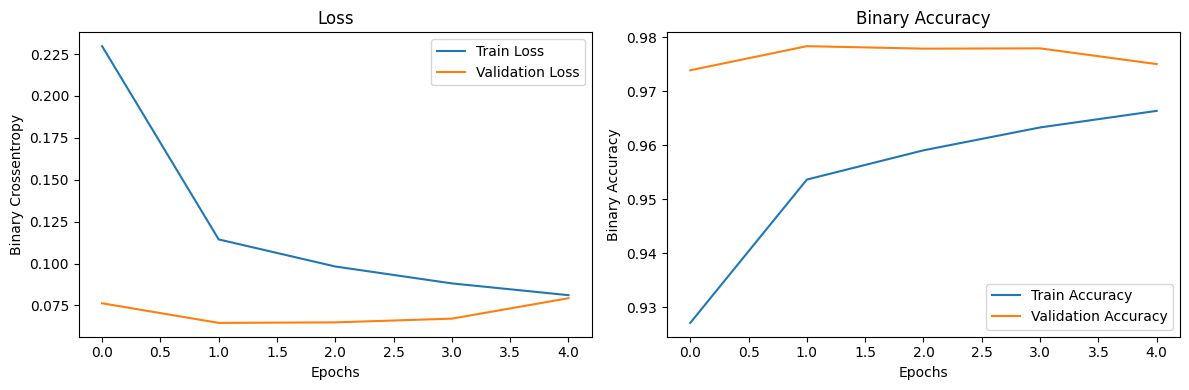

In [ ]:
plot_training_history(history_bal)

In [ ]:
model_bal.save('toxicity_model_bal.keras')

#5.2.B Analisi Modello2

In [ ]:
y_train_pred_prob_bal = model_bal.predict(X_train_bal_seq)
best_thres_bal, best_score_bal = find_best_threshold(y_train_bal, y_train_pred_prob_bal)

3799/3799 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
Soglia ottimale trovata: 0.40 (F1 micro = 0.8114)


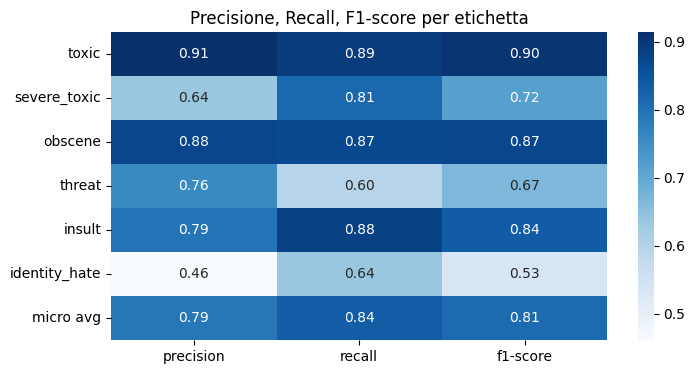

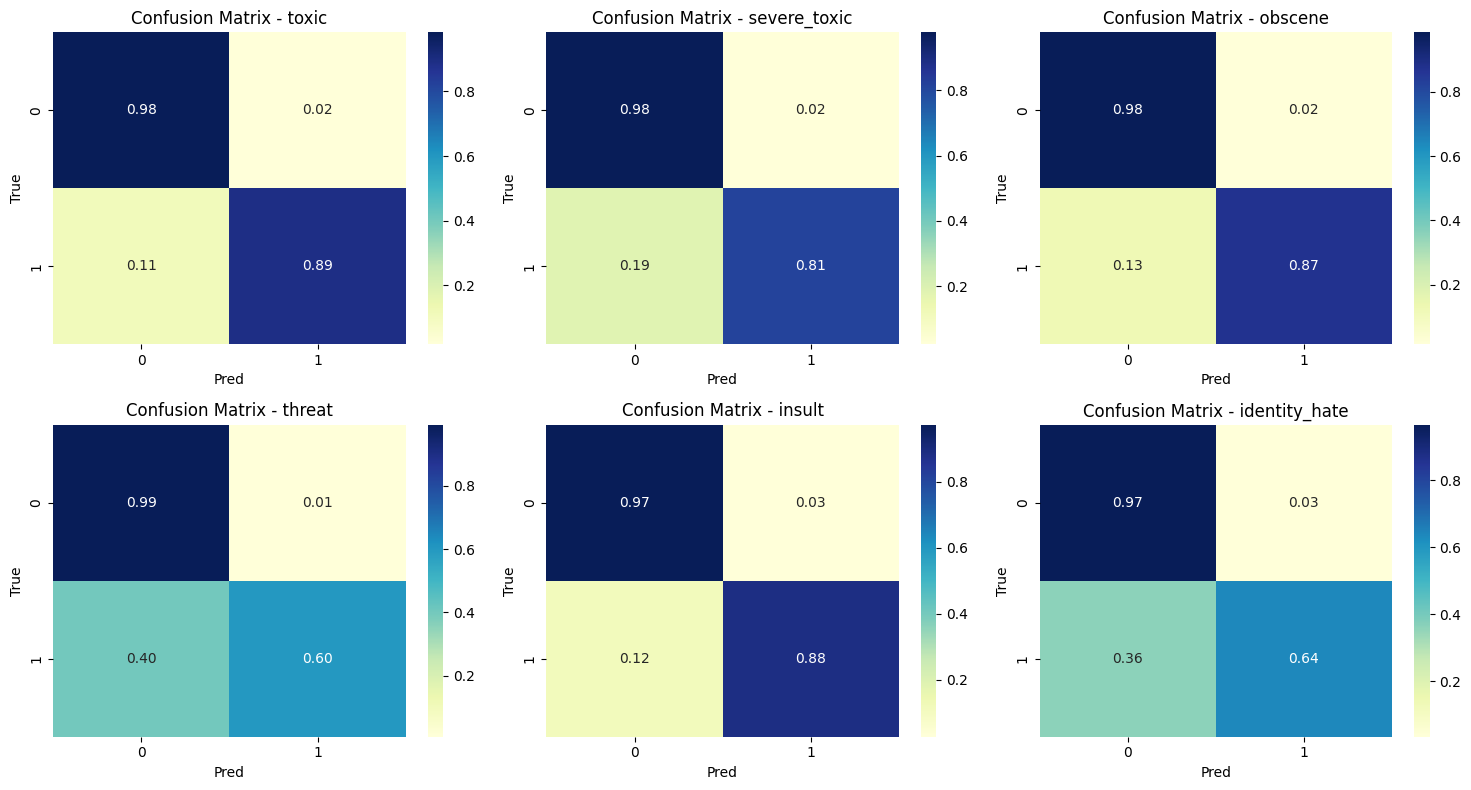

Valutazione globale:
Subset accuracy: 0.8667
F1 micro: 0.8114
F1 macro: 0.7552
Precision micro: 0.7890
Precision macro: 0.7401
Recall micro: 0.8351
Recall macro: 0.7828


,precision,recall,f1-score,support
toxic,0.913602,0.891441,0.902385,20118.0
severe_toxic,0.637681,0.814957,0.715502,5723.0
obscene,0.877095,0.871437,0.874257,13332.0
threat,0.757797,0.596418,0.667492,4522.0
insult,0.793621,0.884937,0.836795,13019.0
identity_hate,0.460852,0.637502,0.534972,5429.0
micro avg,0.788966,0.835090,0.811373,62143.0


In [ ]:
analyze_multilabel_performance(y_train_bal, y_train_pred_prob_bal, labels, best_thres_bal)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


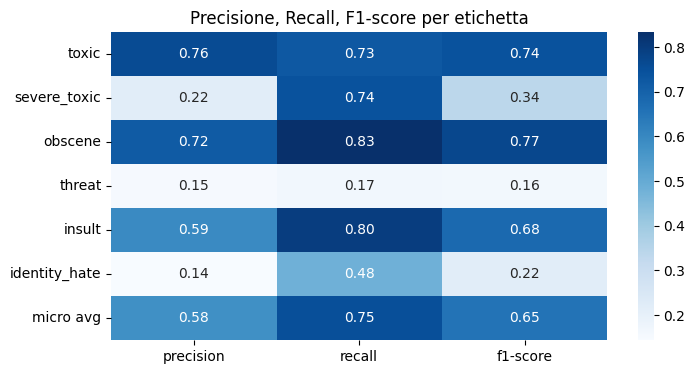

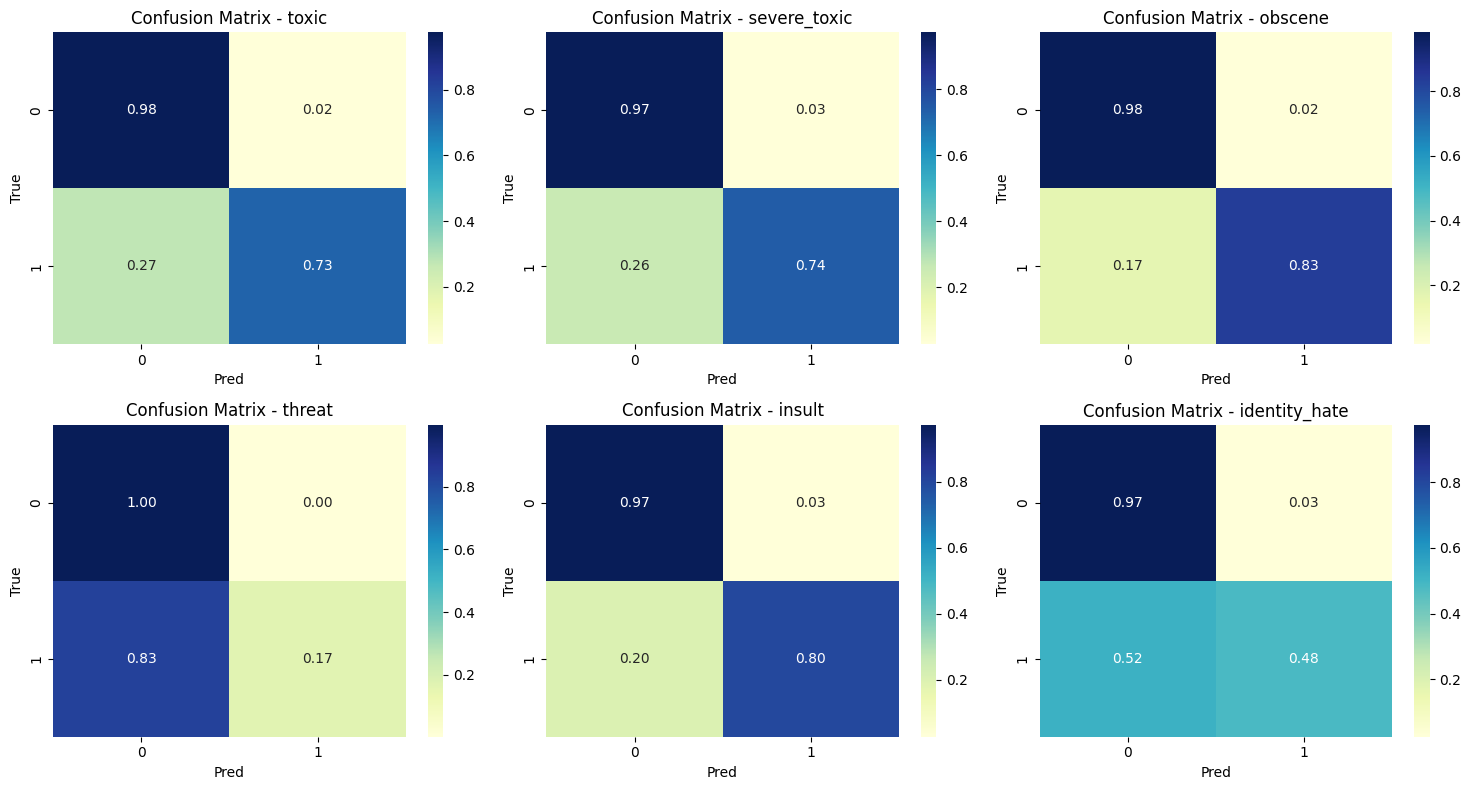

Valutazione globale:
Subset accuracy: 0.8937
F1 micro: 0.6535
F1 macro: 0.4862
Precision micro: 0.5781
Precision macro: 0.4318
Recall micro: 0.7514
Recall macro: 0.6249


,precision,recall,f1-score,support
toxic,0.760438,0.726619,0.743144,1529.0
severe_toxic,0.220370,0.743750,0.340000,160.0
obscene,0.719101,0.833136,0.771930,845.0
threat,0.153846,0.166667,0.160000,48.0
insult,0.593573,0.796954,0.680390,788.0
identity_hate,0.143763,0.482270,0.221498,141.0
micro avg,0.578128,0.751353,0.653456,3511.0


In [ ]:
y_test_pred_prob_bal = model_bal.predict(X_test_seq)
analyze_multilabel_performance(y_test, y_test_pred_prob_bal, labels, best_thres_bal)

Rispetto al modello 1, riusciamo ad intercettare in qualche caso le classi minoritarie ma ancora con valori non soddisfacenti.

Proviamo ad intervenire sull'architettura della nostra rete neurale.

#5.3.A Costruzione e addestramento modello LSTM Bidirezionale

In [ ]:
def build_bidirectional_lstm_model(vocab_size, embedding_dim, lstm_units, input_length, output_dim):
  model = Sequential([
      Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
      Bidirectional(LSTM(lstm_units, return_sequences=True)),
      GlobalMaxPooling1D(),
      Dense(64, activation='relu'),
      Dropout(0.3),
      Dense(output_dim, activation='sigmoid')
  ])

  model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['binary_accuracy']
  )

  model.build(input_shape = (None, input_length))
  print(model.summary())

  return model

In [ ]:
#Parametri
embedding_dim = 128
lstm_units = 64

model_bal_bid = build_bidirectional_lstm_model(
    vocab_size = VOCAB_SIZE,
    embedding_dim = embedding_dim,
    lstm_units = lstm_units,
    input_length = max_len_train,
    output_dim = len(labels)
)
#Addestramento
history_bal_bid = model_bal_bid.fit(
    X_train_bal_seq, y_train_bal,
    validation_data = (X_test_seq, y_test),
    epochs = 5,
    batch_size = 32,
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 115, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 115, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,462 (10.18 MB)

 Trainable params: 2,667,462 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - binary_accuracy: 0.9462 - loss: 0.1471 - val_binary_accuracy: 0.9815 - val_loss: 0.0543
Epoch 2/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - binary_accuracy: 0.9693 - loss: 0.0800 - val_binary_accuracy: 0.9798 - val_loss: 0.0543
Epoch 3/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - binary_accuracy: 0.9770 - loss: 0.0620 - val_binary_accuracy: 0.9807 - val_loss: 0.0550
Epoch 4/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - binary_accuracy: 0.9808 - loss: 0.0509 - val_binary_accuracy: 0.9802 - val_loss: 0.0621
Epoch 5/5
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - binary_accuracy: 0.9836 - loss: 0.0434 - val_binary_accuracy: 0.9793 - val_loss: 0.0657


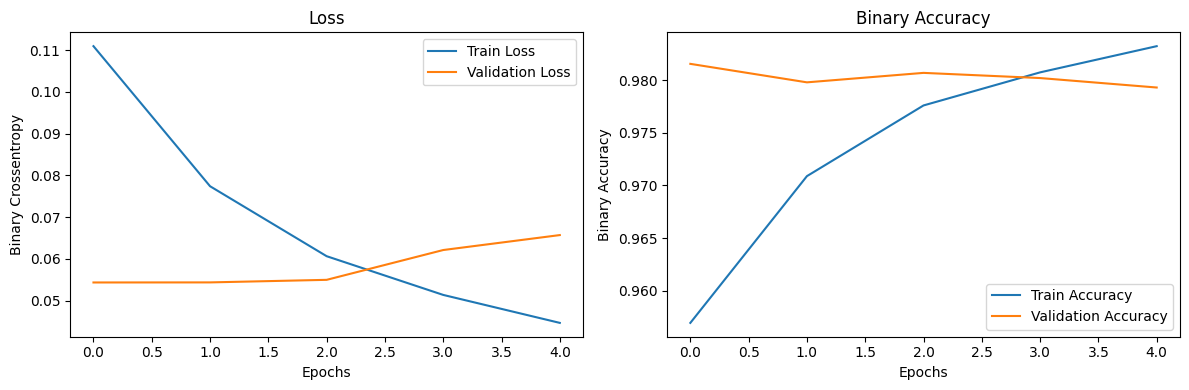

In [ ]:
plot_training_history(history_bal_bid)

In [ ]:
model_bal_bid.save('toxicity_model_bal_bid.keras')

#5.3.B Analisi Modello 3

In [ ]:
y_train_pred_prob_bal_bid = model_bal_bid.predict(X_train_bal_seq)
best_thres_bal_bid, best_score_bal_bid = find_best_threshold(y_train_bal, y_train_pred_prob_bal_bid)

3799/3799 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
Soglia ottimale trovata: 0.45 (F1 micro = 0.9231)


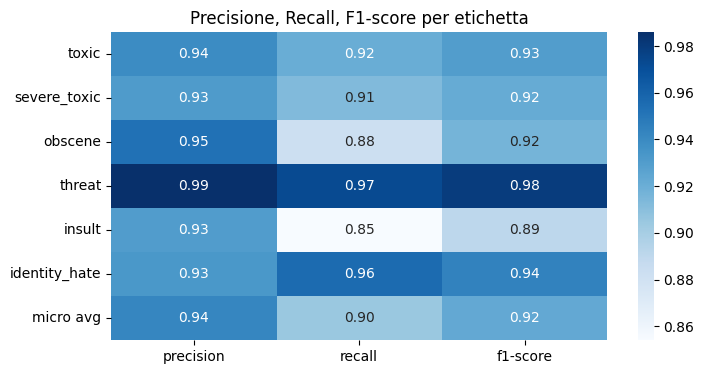

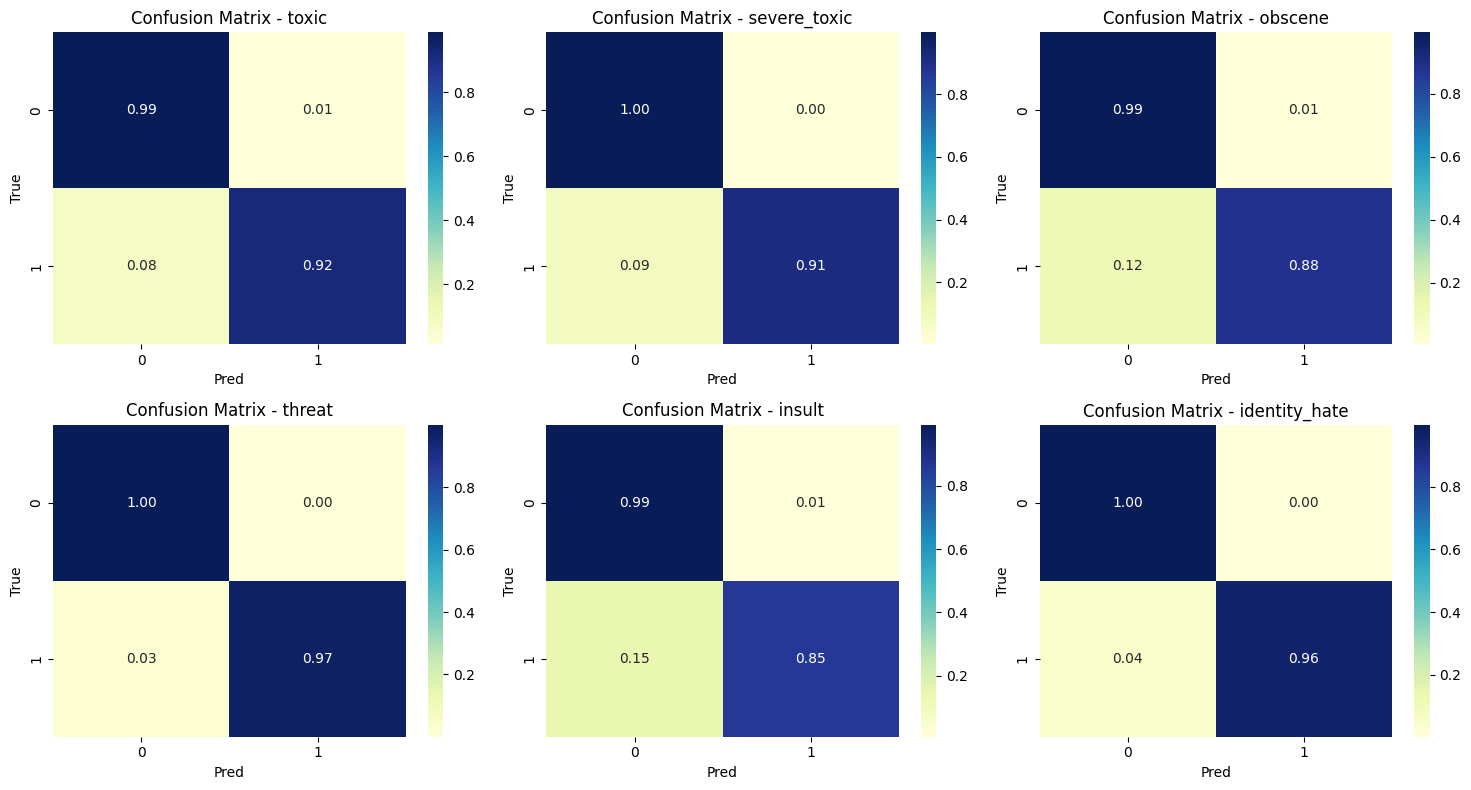

Valutazione globale:
Subset accuracy: 0.9450
F1 micro: 0.9231
F1 macro: 0.9304
Precision micro: 0.9424
Precision macro: 0.9453
Recall micro: 0.9047
Recall macro: 0.9165


,precision,recall,f1-score,support
toxic,0.939285,0.920469,0.929782,20118.0
severe_toxic,0.930875,0.912983,0.921842,5723.0
obscene,0.952500,0.882913,0.916388,13332.0
threat,0.985881,0.972800,0.979297,4522.0
insult,0.930454,0.853983,0.890580,13019.0
identity_hate,0.932950,0.955977,0.944323,5429.0
micro avg,0.942357,0.904704,0.923146,62143.0


In [ ]:
analyze_multilabel_performance(y_train_bal, y_train_pred_prob_bal_bid, labels, best_thres_bal_bid)

499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


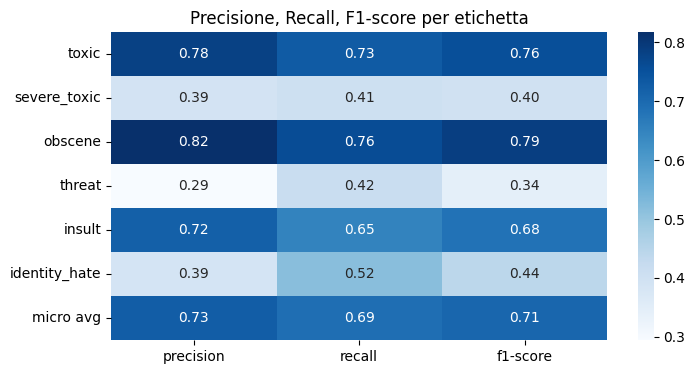

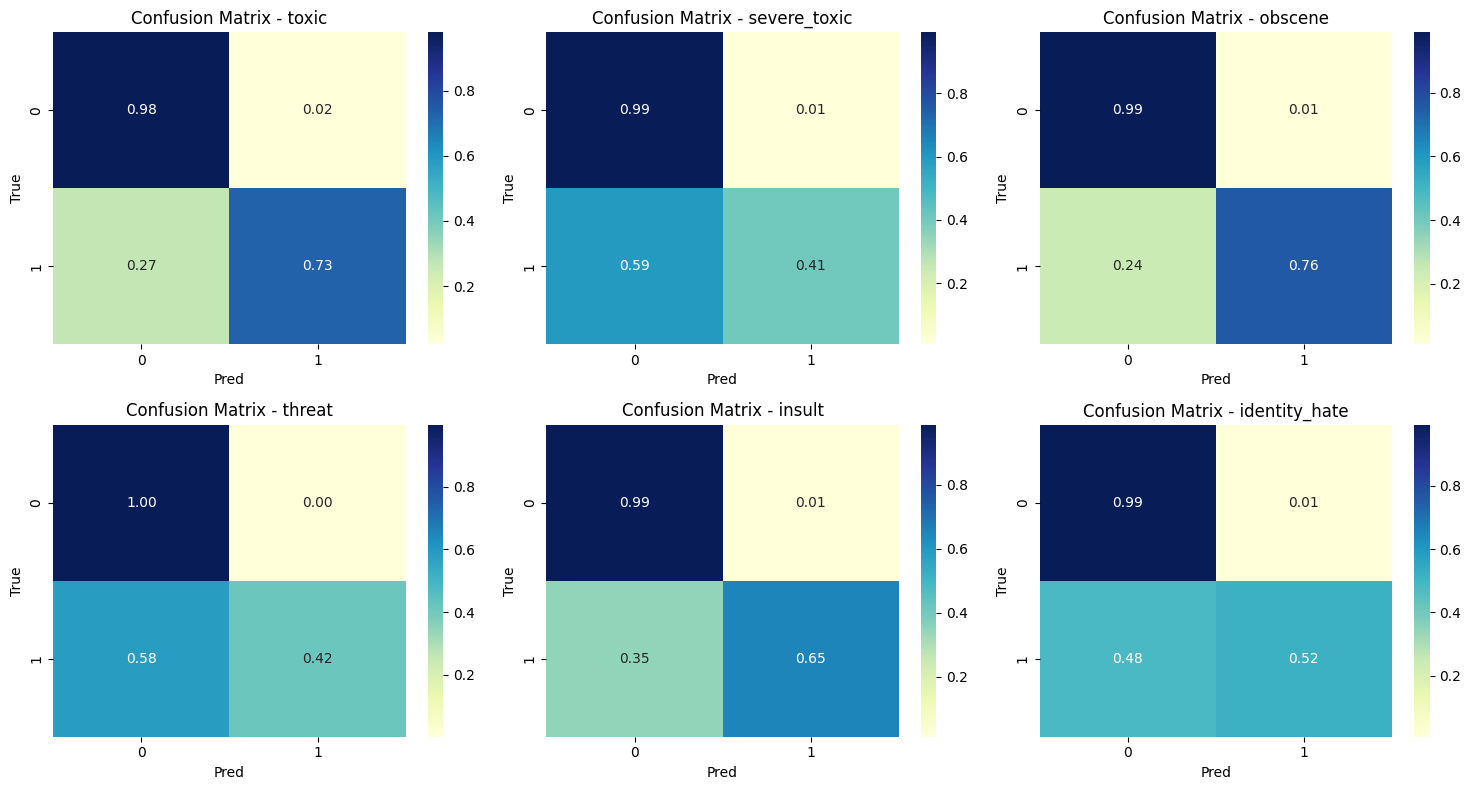

Valutazione globale:
Subset accuracy: 0.9091
F1 micro: 0.7080
F1 macro: 0.5685
Precision micro: 0.7256
Precision macro: 0.5651
Recall micro: 0.6913
Recall macro: 0.5799


,precision,recall,f1-score,support
toxic,0.783006,0.729235,0.755164,1529.0
severe_toxic,0.391566,0.406250,0.398773,160.0
obscene,0.816794,0.759763,0.787247,845.0
threat,0.294118,0.416667,0.344828,48.0
insult,0.719101,0.649746,0.682667,788.0
identity_hate,0.386243,0.517730,0.442424,141.0
micro avg,0.725561,0.691256,0.707993,3511.0


In [ ]:
y_test_pred_prob_bal_bid = model_bal_bid.predict(X_test_seq)
analyze_multilabel_performance(y_test, y_test_pred_prob_bal_bid, labels, best_thres_bal_bid)

Confrontando gli ultimi due modelli possiamo notare che aver bilanciato il dataset ha permesso ad entrambi di individuare almeno in parte anche le etichette più rare.

Il modello con LSTM Bidirezionale si fa preferire in quasi tutte le metriche, anche se presenta dell'overfitting, questo appare essere il modello più promettente.

# 6 Modello di Deep Learning con LSTM Bidirezionale

Aumnentiamo il dropout rispetto al modello precedente per cercare di limitare l'overfitting.

In [ ]:
def build_bidirectional_lstm_model_v2(vocab_size, embedding_dim, lstm_units, input_length, output_dim):
  model = Sequential([
      Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
      Bidirectional(LSTM(lstm_units, return_sequences=True)),
      GlobalMaxPooling1D(),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(output_dim, activation='sigmoid')
  ])

  model.compile(
      loss = 'binary_crossentropy',
      optimizer = Adam(learning_rate=5e-4),
      metrics = ['binary_accuracy']
  )

  model.build(input_shape = (None, input_length))
  print(model.summary())

  return model

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

embedding_dim = 128
lstm_units = 64

model_v2 = build_bidirectional_lstm_model_v2(
    vocab_size = VOCAB_SIZE,
    embedding_dim = embedding_dim,
    lstm_units = lstm_units,
    input_length = max_len_train,
    output_dim = len(labels)
)

history_v2 = model_v2.fit(
    X_train_bal_seq, y_train_bal,
    validation_data = (X_test_seq, y_test),
    epochs = 30,
    batch_size = 32,
    verbose=1,
    callbacks = [early_stop]
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 115, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 115, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,462 (10.18 MB)

 Trainable params: 2,667,462 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - binary_accuracy: 0.9402 - loss: 0.1728 - val_binary_accuracy: 0.9810 - val_loss: 0.0529
Epoch 2/30
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - binary_accuracy: 0.9625 - loss: 0.0929 - val_binary_accuracy: 0.9802 - val_loss: 0.0558
Epoch 3/30
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - binary_accuracy: 0.9689 - loss: 0.0791 - val_binary_accuracy: 0.9804 - val_loss: 0.0550
Epoch 4/30
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - binary_accuracy: 0.9732 - loss: 0.0703 - val_binary_accuracy: 0.9797 - val_loss: 0.0565


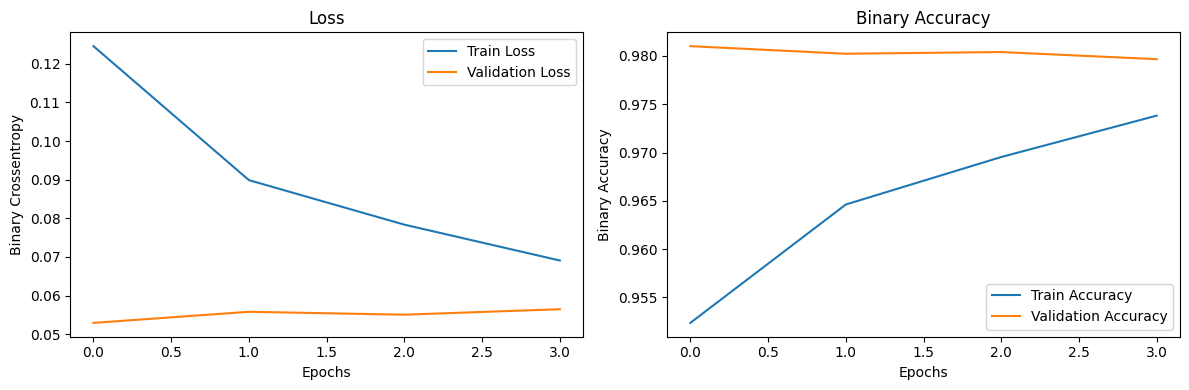

3799/3799 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
Soglia ottimale trovata: 0.40 (F1 micro = 0.7803)


----------Valutazione modello v2: TRAIN-----------


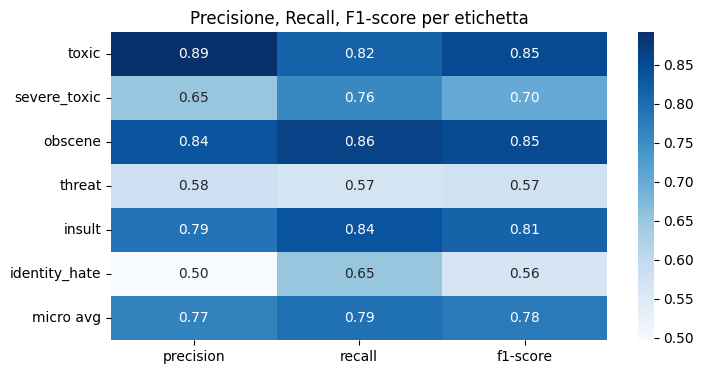

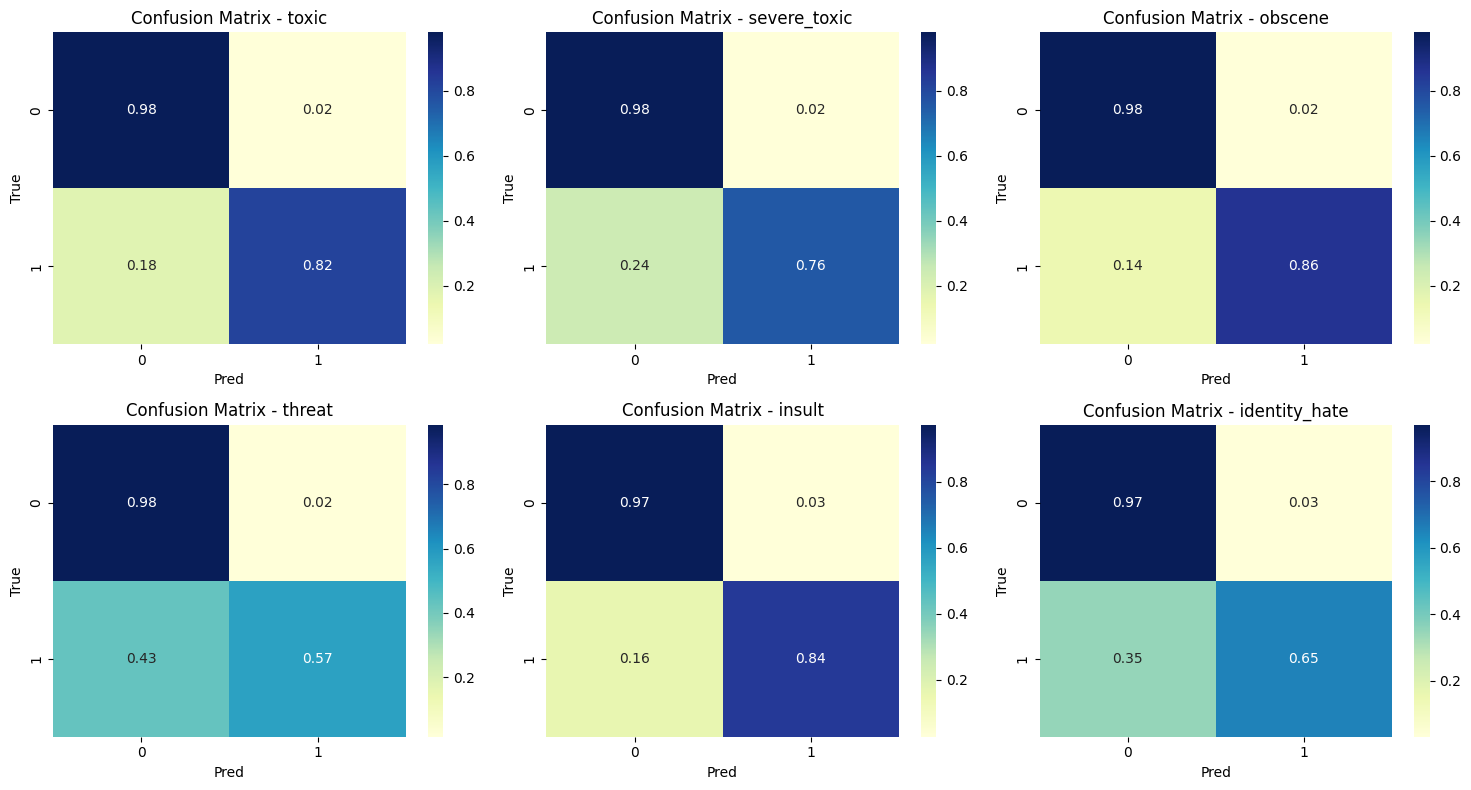

Valutazione globale:
Subset accuracy: 0.8551
F1 micro: 0.7803
F1 macro: 0.7258
Precision micro: 0.7678
Precision macro: 0.7079
Recall micro: 0.7932
Recall macro: 0.7494
               precision    recall  f1-score  support
toxic           0.891538  0.815936  0.852063  20118.0
severe_toxic    0.651658  0.758693  0.701114   5723.0
obscene         0.837226  0.863036  0.849935  13332.0
threat          0.580529  0.568333  0.574366   4522.0
insult          0.789687  0.838697  0.813455  13019.0
identity_hate   0.496700  0.651501  0.563665   5429.0
micro avg       0.767825  0.793154  0.780284  62143.0


----------Valutazione modello v2: TEST-----------
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


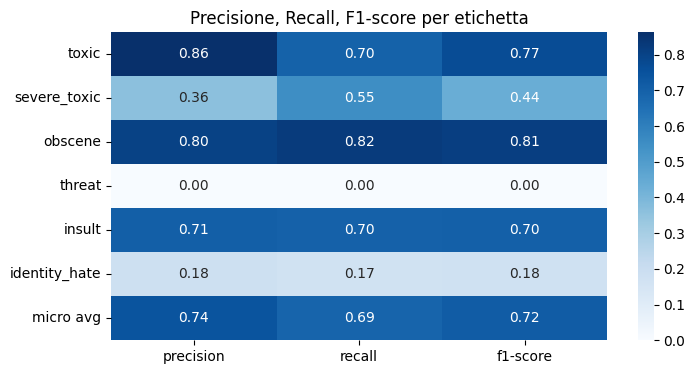

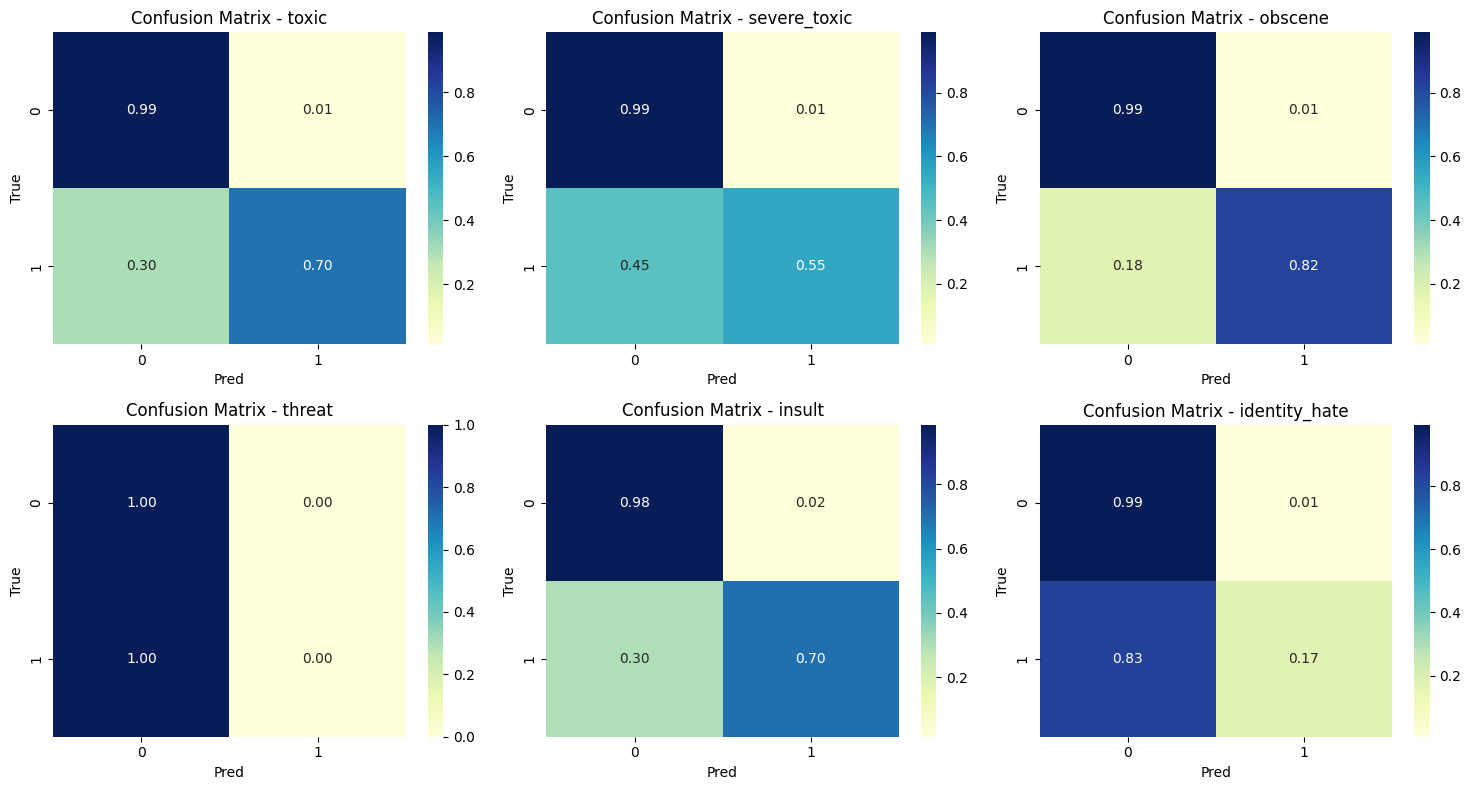

Valutazione globale:
Subset accuracy: 0.9141
F1 micro: 0.7160
F1 macro: 0.4836
Precision micro: 0.7439
Precision macro: 0.4868
Recall micro: 0.6901
Recall macro: 0.4898
               precision    recall  f1-score  support
toxic           0.862237  0.695880  0.770177   1529.0
severe_toxic    0.363636  0.550000  0.437811    160.0
obscene         0.803695  0.823669  0.813559    845.0
threat          0.000000  0.000000  0.000000     48.0
insult          0.706410  0.699239  0.702806    788.0
identity_hate   0.184615  0.170213  0.177122    141.0
micro avg       0.743936  0.690117  0.716017   3511.0


In [ ]:
model_v2.save('toxicity_model_bal_bid_v2.keras')
plot_training_history(history_v2)
y_train_pred_prob_v2 = model_v2.predict(X_train_bal_seq)
best_thres_v2, best_score_v2 = find_best_threshold(y_train_bal, y_train_pred_prob_v2)

print("\n\n----------Valutazione modello v2: TRAIN-----------")
print(analyze_multilabel_performance(y_train_bal, y_train_pred_prob_v2, labels, best_thres_v2))

print("\n\n----------Valutazione modello v2: TEST-----------")
y_test_pred_prob_v2 = model_v2.predict(X_test_seq)
print(analyze_multilabel_performance(y_test, y_test_pred_prob_v2, labels, best_thres_v2))

# 6.1 Valutazione sul Validation set



----------Valutazione modello v2: VALIDATION-----------
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


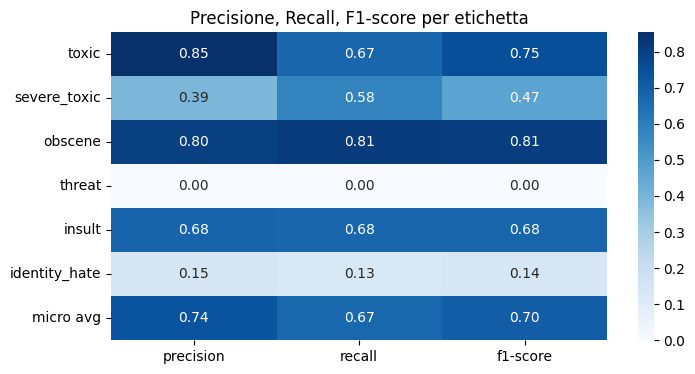

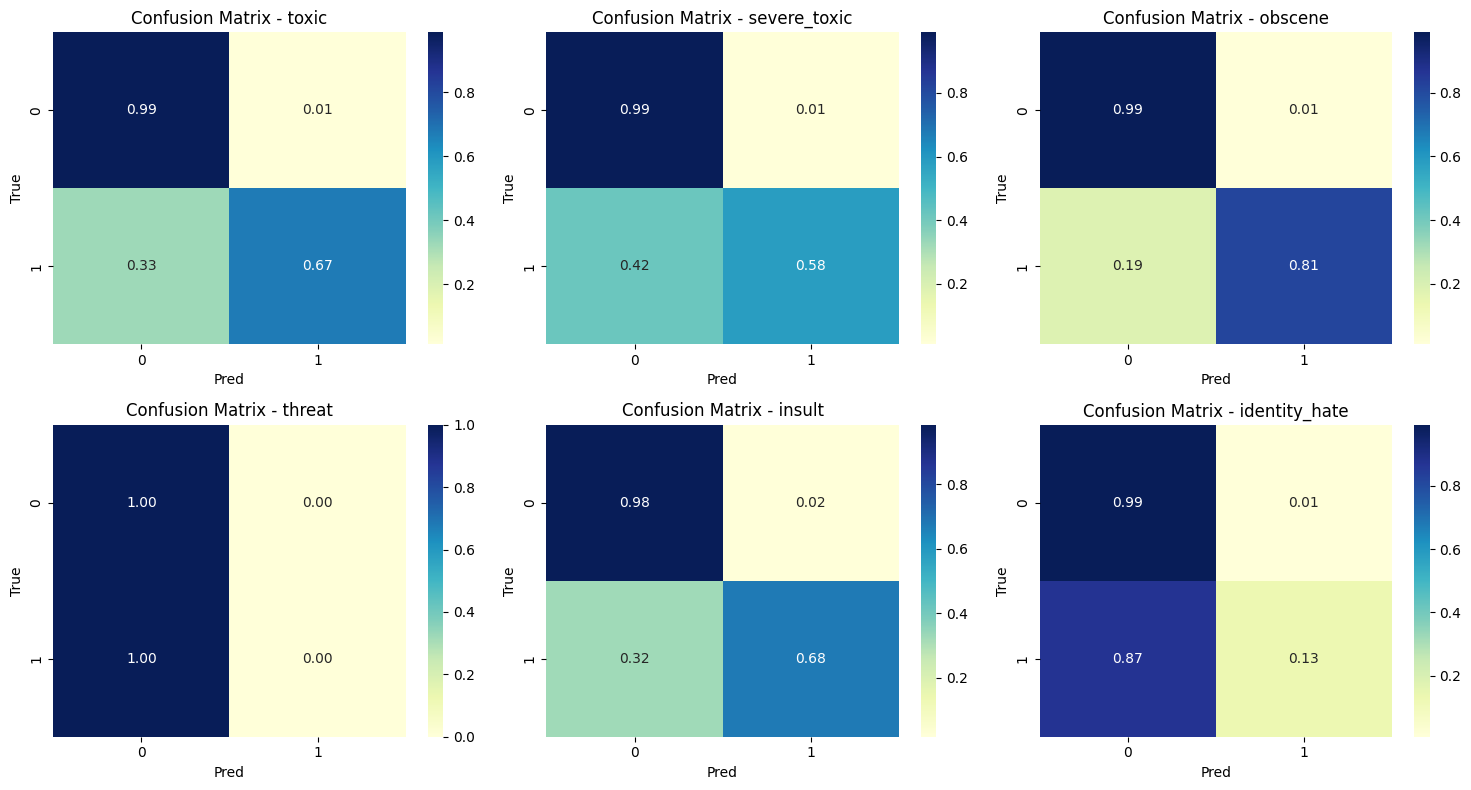

Valutazione globale:
Subset accuracy: 0.9126
F1 micro: 0.7036
F1 macro: 0.4746
Precision micro: 0.7372
Precision macro: 0.4801
Recall micro: 0.6729
Recall macro: 0.4791
               precision    recall  f1-score  support
toxic           0.853477  0.674076  0.753242   3059.0
severe_toxic    0.392405  0.583072  0.469105    319.0
obscene         0.802217  0.813609  0.807873   1690.0
threat          0.000000  0.000000  0.000000     95.0
insult          0.682489  0.675556  0.679004   1575.0
identity_hate   0.150000  0.128114  0.138196    281.0
micro avg       0.737162  0.672888  0.703560   7019.0


In [ ]:
print("\n\n----------Valutazione modello v2: VALIDATION-----------")
y_val_pred_prob_v2 = model_v2.predict(X_val_seq)
print(analyze_multilabel_performance(y_val, y_val_pred_prob_v2, labels, best_thres_v2))

#7 Considerazioni finali

Al termine della fase di sperimentazione, il modello selezionato è una reta **Bidirectional LSTM** addestrata con **batch size** di 32 e **ottimizzatore Adam** con **learining rate** di 5e-4. La scelta è stata guidata dall'obiettivo di massimizzare la **subset accuracy, il micro F1-score** e la **precisione globale**, senza penalizzare eccessivamente le classi minoritarie.

Il modello ha mostrato prestazioni complessivamente bilanciate, con una buona generalizzazione sui tre insiemi di dati:
- **Training set**
  - Subset accuracy: 0.86
  - F1 micro 0.78, F1 macro: 0.73
  - Precision micro: 0.77
  - Recall micro: 0.79

- **Test set**
  - Subset accuracy: 0.91
  - F1 micro 0.72, F1 macro: 0.48
  - Precision micro: 0.74
  - Recall micro: 0.69

- **Validation set**
  - Subset accuracy: 0.91
  - F1 micro 0.70, F1 macro: 0.47
  - Precision micro: 0.74
  - Recall micro: 0.67

In particolare, le classi maggioritarie(**toxic, obscene, insult**) mostrano valori elevati di F1-score, mentre il modello riesce comunque a cogliere segnali utili anche dalle classi meno rappresentate, pur con margini di miglioramento.

Tuttavia, è importante sittolineare che le classi minoritarie, in particolare **threat** e **identity_hate**, non sono state rilevate in modo efficare. Questo è dovuto alla forte sproporzione nei dati, che ha limitato la capacità del modello di apprendere pattern affidabili per queste categorie. In particolare, la classe **threat** ha mostrato F1-score pari a zero nel test e nel validation set, segno di una mancata identificazione. Per queste etichette sarebbe stato necessario aver raccolto più dati.